# Artificial Intelligence: A technical overview from a 500 ft view

In [2]:
print('hello world')

hello world


# Computer vision: Image classification

#### Imports

In [1]:
!pip install fastcore
!pip install fastprogress
!pip install fastai
!pip install torcheval
!pip install --upgrade huggingface_hub

import sys 
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
parent_dir
sys.path.append(parent_dir)

import torch,random
import fastcore.all as fc
from torch import nn
from torch.nn import init
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.training import *
from miniai.datasets import DataLoaders as miniai_DataLoaders
import huggingface_hub
print(huggingface_hub.__version__)
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy, BinaryAccuracy, Mean
from datasets import load_dataset,load_dataset_builder
from fastcore.test import test_close
from torch import distributions
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
import logging
logging.disable(logging.WARNING)
from fastai.data.external import untar_data
from fastai.vision.all import *    #URLs, TensorImage, ImageDataLoaders
from IPython.display import Image as IMG
import pandas as pd

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8
print('Done with imports')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 5.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.7/450.7 kB 7.1 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
0.27.1
Done with imports


## Simple Neural Network

#### Here's our basic training loop:

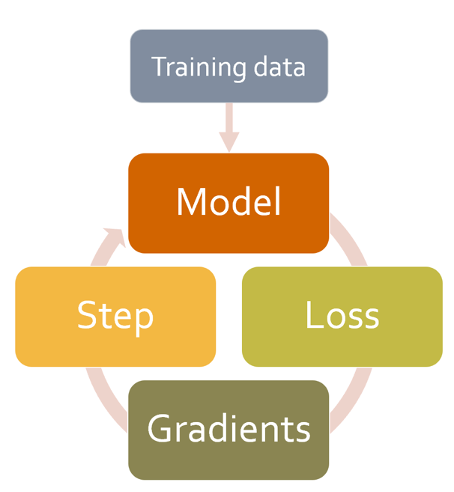

In [30]:
IMG("../AI_USU/Images/Tng_loop.png")

#### Basic Neural Network Terminology:

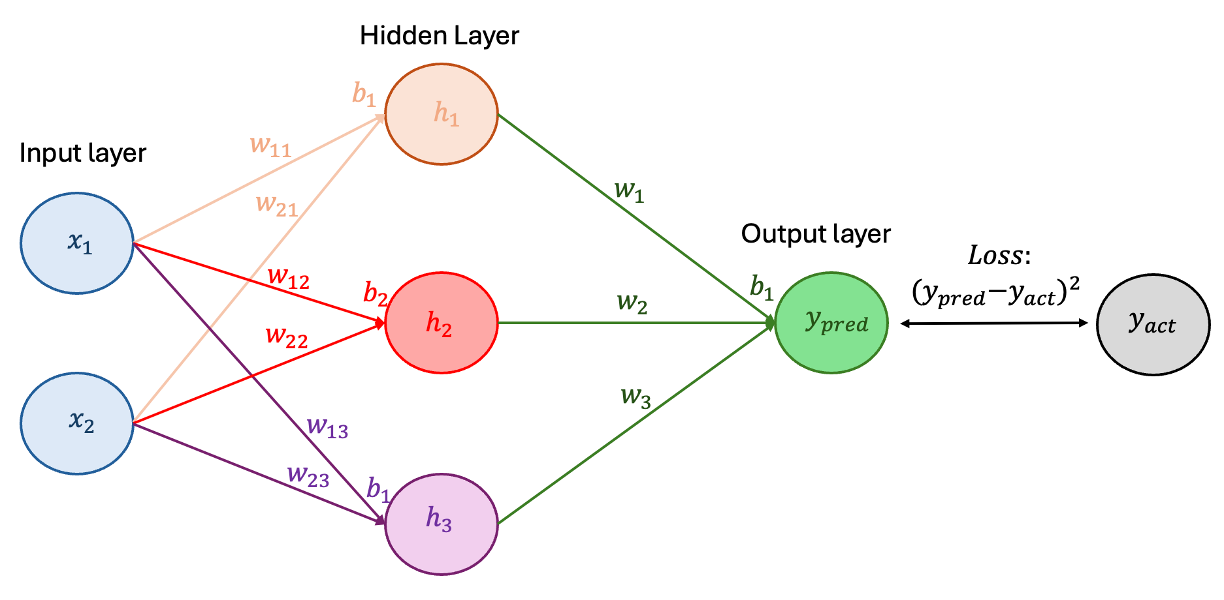

In [31]:
IMG("../AI_USU/Images/SimpleNN.png")

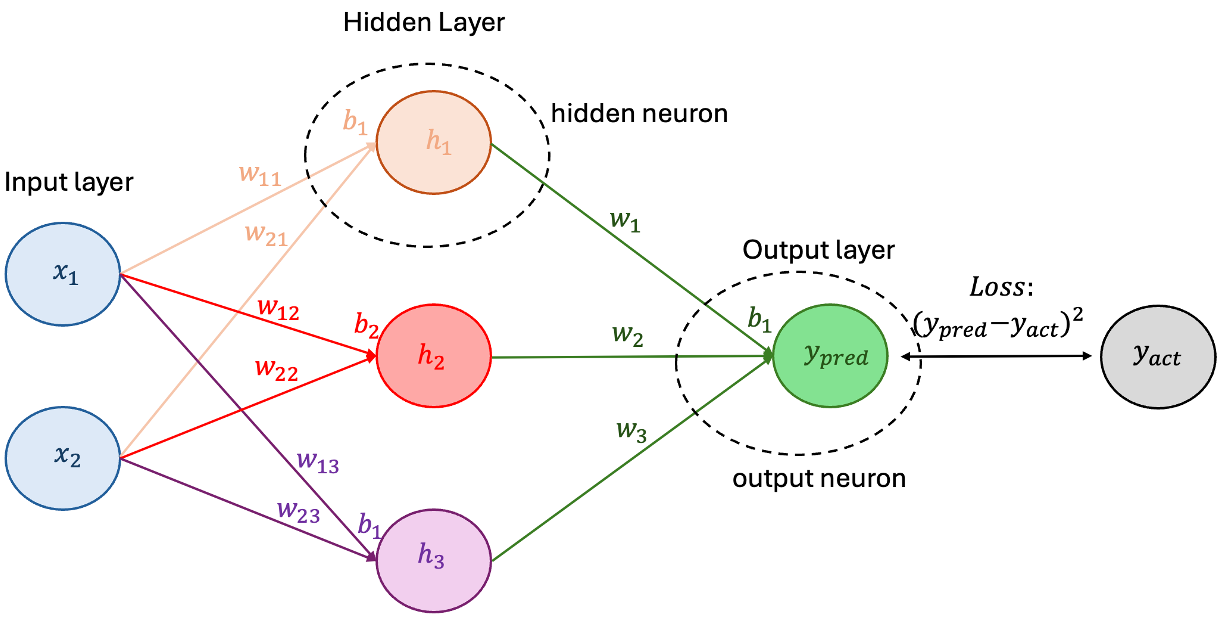

In [32]:
IMG("../AI_USU/Images/SimpleNN_NeuronOutline.png")

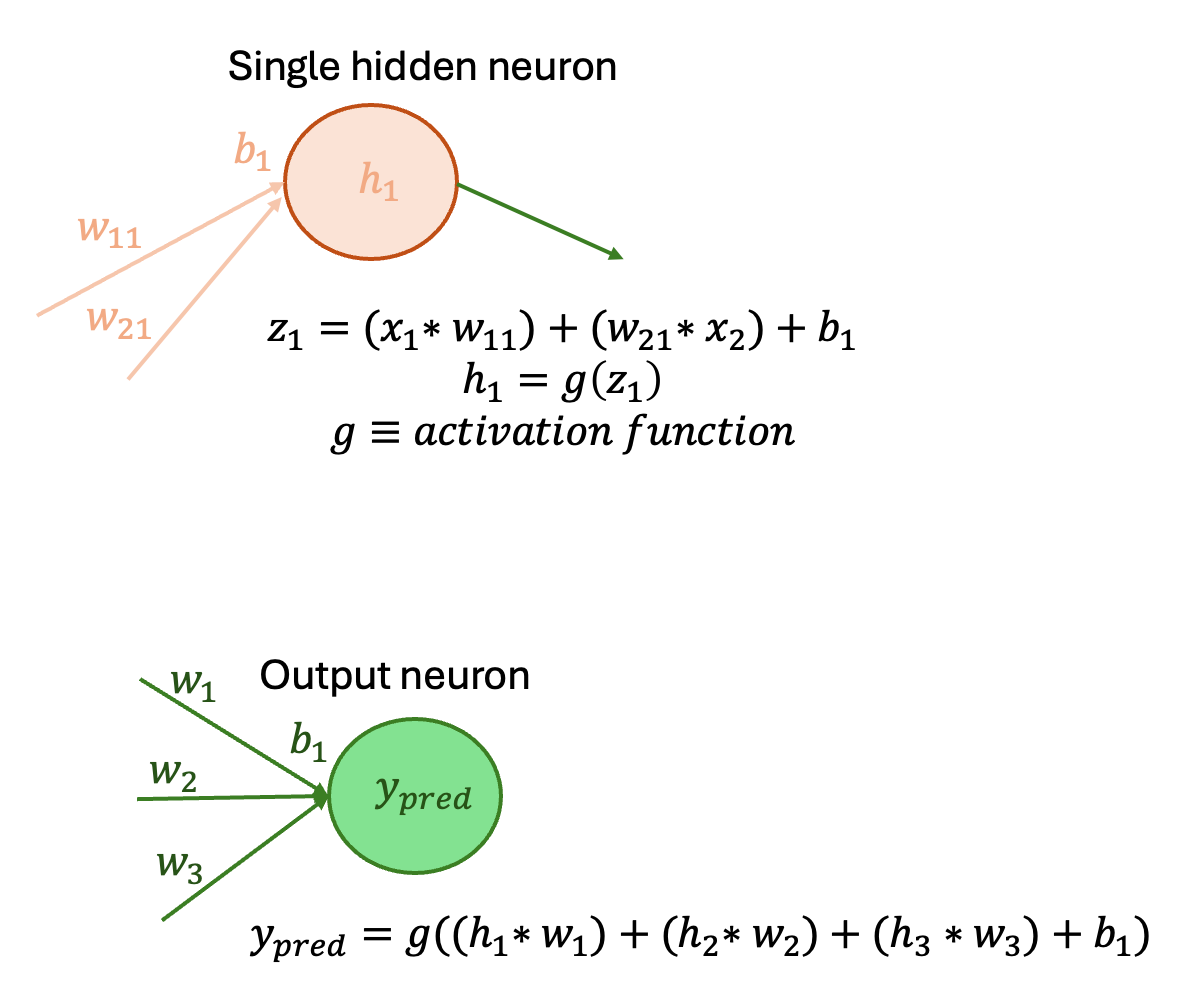

In [33]:
IMG("../AI_USU/Images/Single_neuron.png")

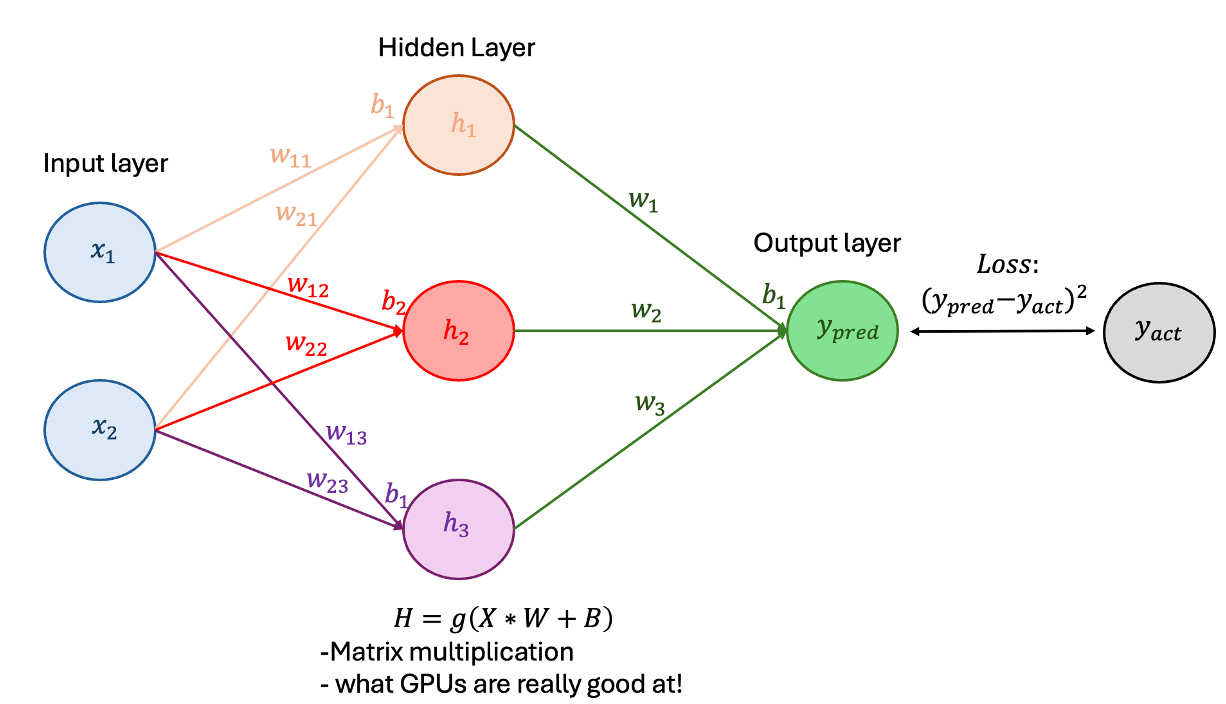

In [34]:
IMG("../AI_USU/Images/SimpleNN_matmul.png")

### Let's try an example: MNIST Dataset

#### STEP 1: Gather our data

/root/.fastai/data/mnist_sample


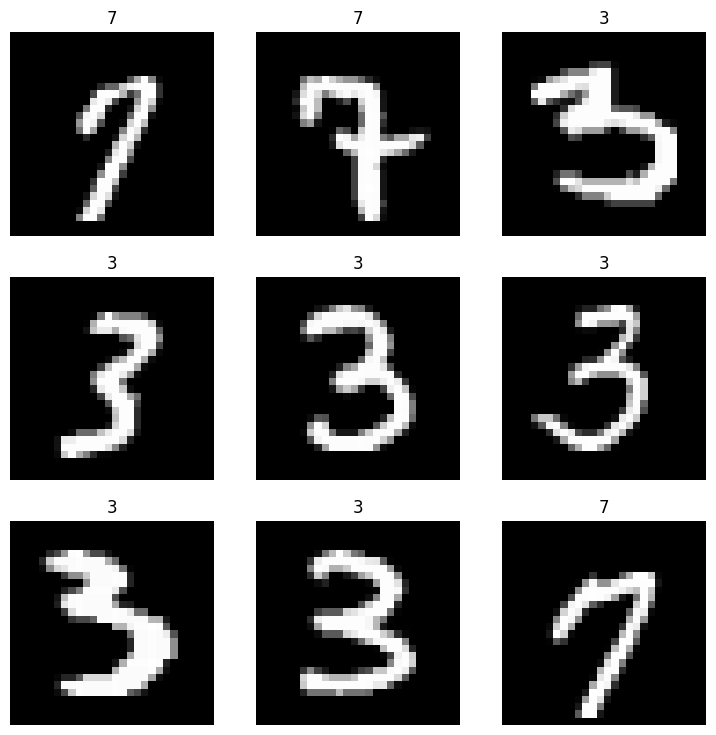

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
print(path)
dls_ex = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, bs=64)
dls_ex.show_batch()

In [4]:
mnist_block = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(28),
    batch_tfms=[IntToFloatTensor, lambda x: x.view(x.size(0), -1)] 
)

dls_sample = mnist_block.dataloaders(path, bs=64)

In [5]:
path_3 = path/'train'/'7'

image_files = [f.name for f in path_3.glob('*.png')]

from PIL import Image

im3 = Image.open(path/'train'/'3'/'12.png')
im3_t = TensorImage(im3)
im7 = Image.open(path/'train'/'7'/'33651.png')
im7_t = TensorImage(im7)

df = pd.DataFrame(im3_t[:,:])
pd.set_option('display.max_columns', 28)
df.style.set_properties(**{'font-size':'9pt'}).background_gradient('Greys')

#### Goal predict whether the image is a 3 or a 7 using a simple neural network

#### STEP 2: Choose a model architecture
 - Neurnal network with 1 hidden layer: 3 layers total

In [6]:
xb_sample, yb_sample = dls_sample.one_batch()
m_sample = xb_sample.shape[1]
nh_sample = 10
m_sample, len(dls_sample.train.dataset)

(784, 11548)

In [7]:
yb_sample.as_subclass(torch.Tensor).squeeze().shape

torch.Size([64])

In [8]:
model_mnist_sample = nn.Sequential(
    nn.Linear(m_sample, nh_sample),
    nn.ReLU(),
    nn.Linear(nh_sample, 1),
    nn.Sigmoid(),
    nn.Flatten()).to(def_device)

preds = model_mnist_sample(xb_sample)
preds.shape, type(preds), type(preds.as_subclass(torch.Tensor))

(torch.Size([64, 1]), fastai.torch_core.TensorImageBW, torch.Tensor)

In [9]:
for name, param in model_mnist_sample.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} | Shape: {param.shape}")
        print(f'{param.data}, Mean: {param.data.mean().item():.3f}, Std: {param.data.std().item():.3f}')

Layer: 0.weight | Shape: torch.Size([10, 784])
tensor([[ 0.03, -0.03,  0.03,  ..., -0.03, -0.02, -0.03],
        [-0.02, -0.02,  0.02,  ..., -0.01,  0.01,  0.03],
        [-0.01,  0.00,  0.02,  ...,  0.00, -0.03, -0.02],
        ...,
        [-0.03,  0.03,  0.00,  ..., -0.01,  0.03, -0.02],
        [-0.01, -0.00, -0.02,  ...,  0.01, -0.03, -0.01],
        [ 0.02,  0.00,  0.03,  ..., -0.01,  0.00, -0.01]], device='cuda:0'), Mean: -0.000, Std: 0.021
Layer: 0.bias | Shape: torch.Size([10])
tensor([-0.03, -0.02, -0.01, -0.01, -0.02, -0.01, -0.03, -0.03,  0.02, -0.01], device='cuda:0'), Mean: -0.014, Std: 0.015
Layer: 2.weight | Shape: torch.Size([1, 10])
tensor([[    -0.10,      0.00,      0.05,     -0.21,      0.14,      0.14,      0.14,     -0.23,      0.28,      0.17]], device='cuda:0'), Mean: 0.039, Std: 0.171
Layer: 2.bias | Shape: torch.Size([1])
tensor([0.09], device='cuda:0'), Mean: 0.090, Std: nan


##### Pics

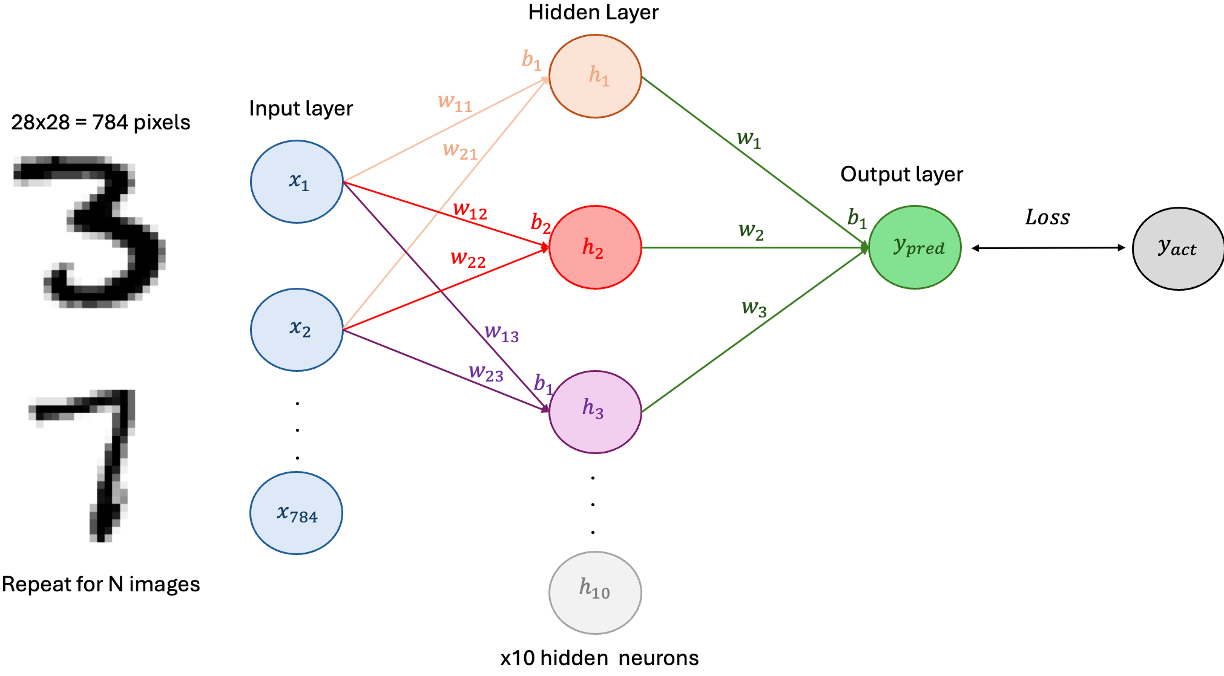

In [35]:
IMG("../AI_USU/Images/Simple_MNIST_NN.png")

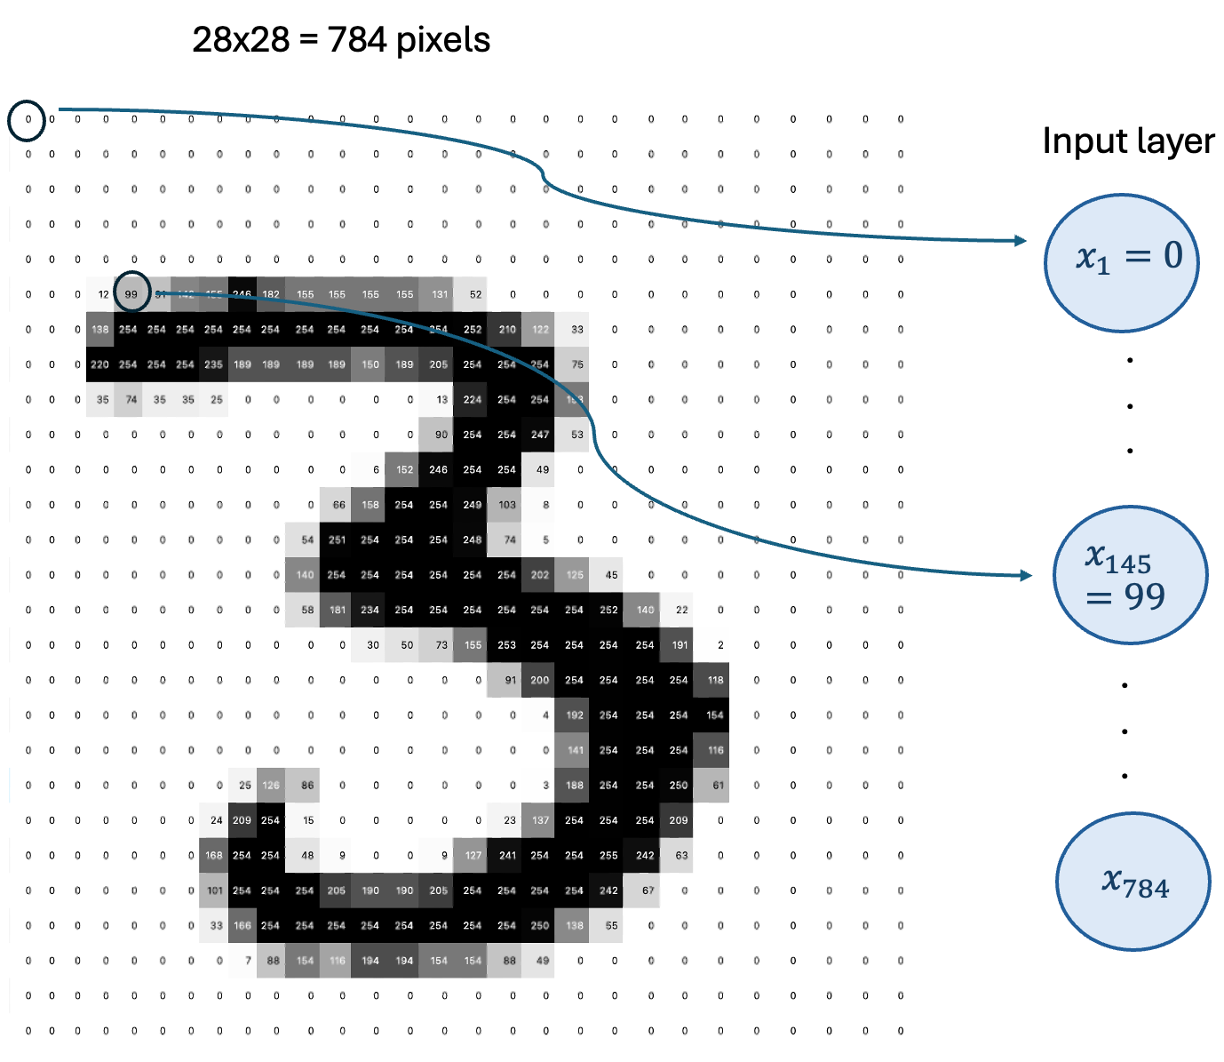

In [36]:
IMG("../AI_USU/Images/SimpleNN_3.png")

#### STEP 3: Randomly initialize our model parameters (w, b)
- mean:0, standard deviation: 1

Let's count our total # of parameters:
- Input layer -> hidden layer: 784*10 + 10
- Hidden layer -> output layer: 10*1 + 1
- Total # parameters: 7861

##### Pics

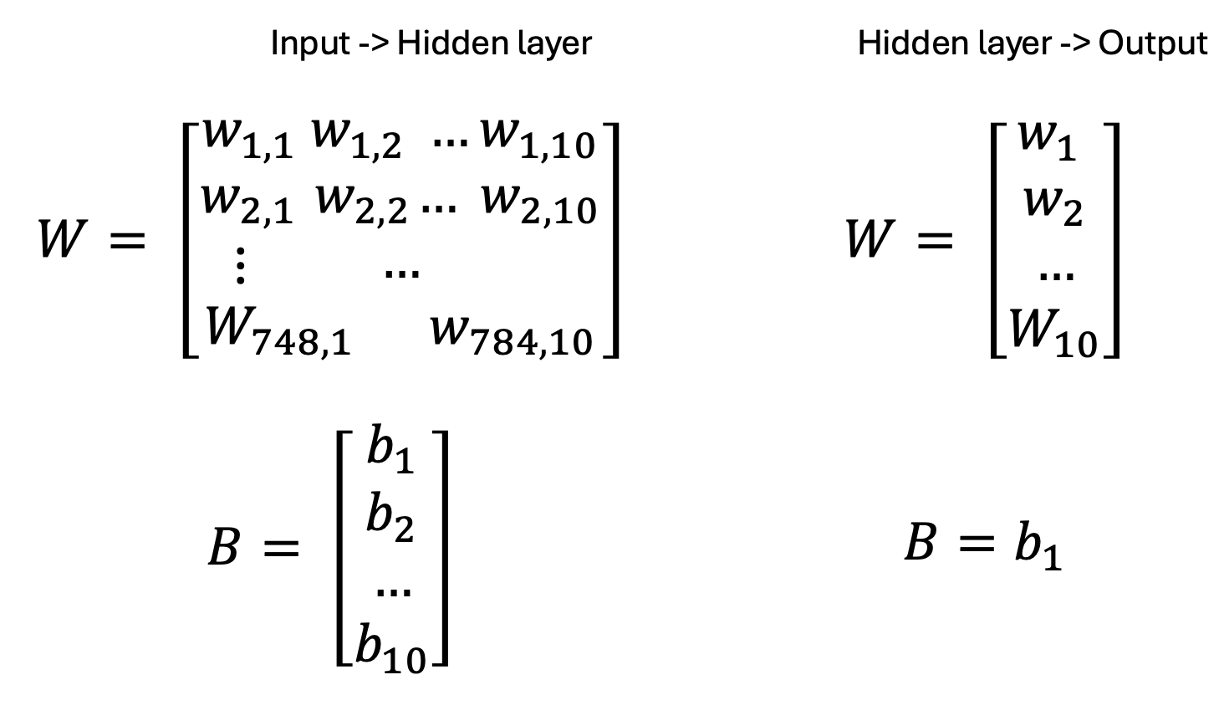

In [37]:
IMG("../AI_USU/Images/Matrices.png")

#### STEP 4: Pass in our data, calculate our loss

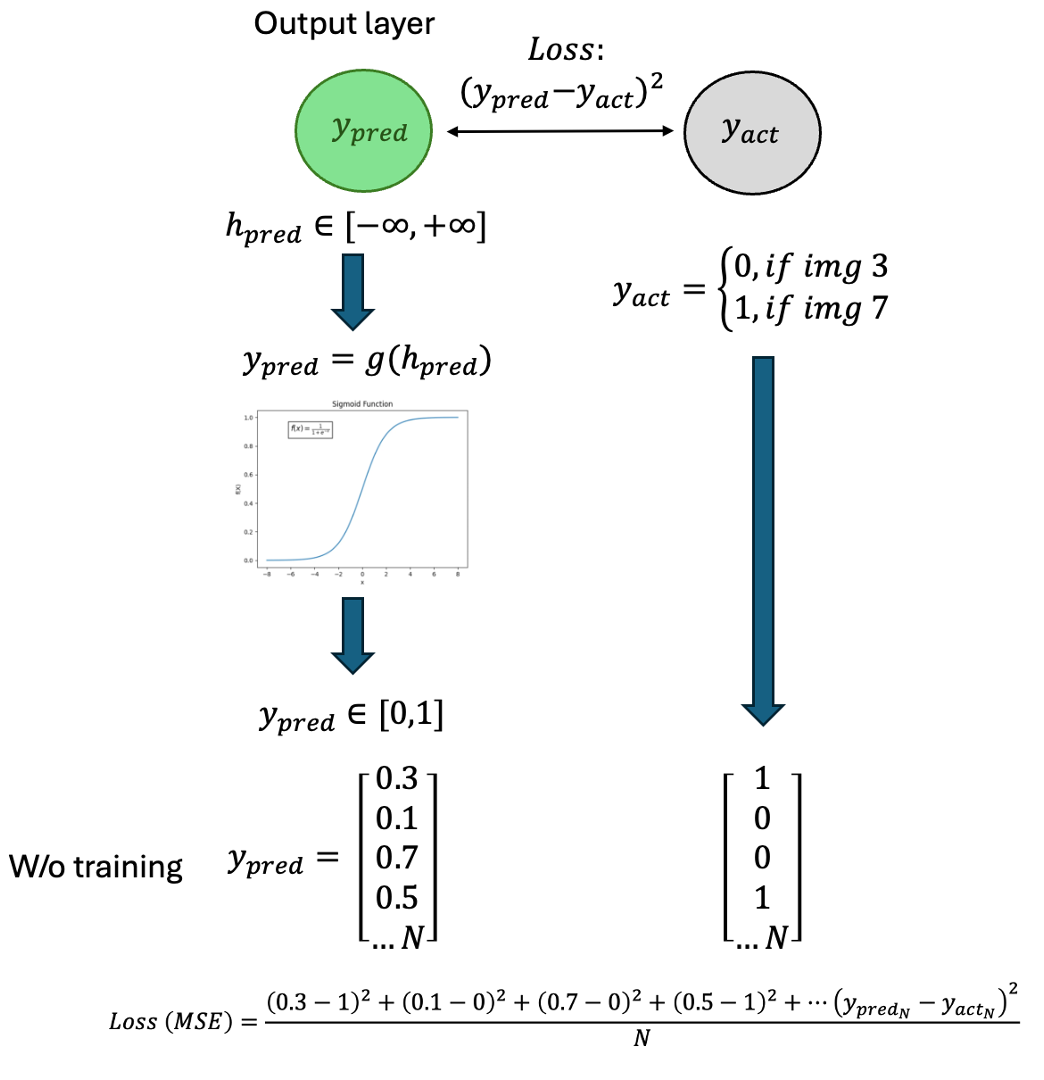

In [38]:
IMG("../AI_USU/Images/NN_loss.png")

We just did a Forward pass through our neural network!

New let's do a backward pass "backward propagation of loss": Backpropagation is an optimization technique used to adjust the weights and biases of a neural network by minimizing the error between the network's predicted output and the actual target output. It works by propagating the error backward from the output layer to the input layer, layer by layer, updating the parameters to reduce the overall error.

#### STEP 5: Calculate our gradients

##### Pics

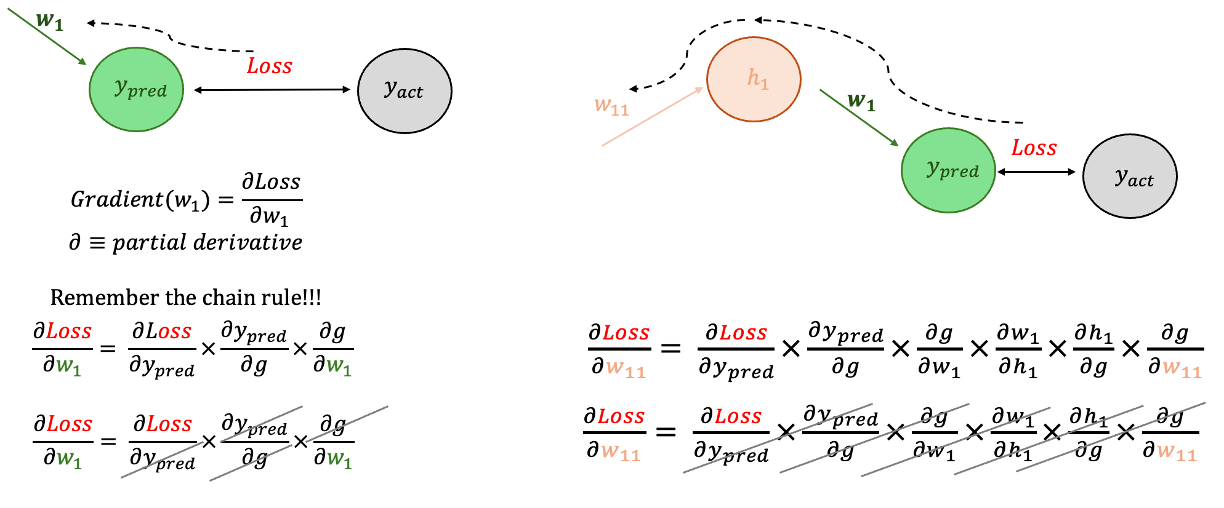

In [39]:
IMG("../AI_USU/Images/NN_grad.png")

#### STEP 6: optimizer, change the model parameters (W, B) in a way that reduces the loss

##### Pics

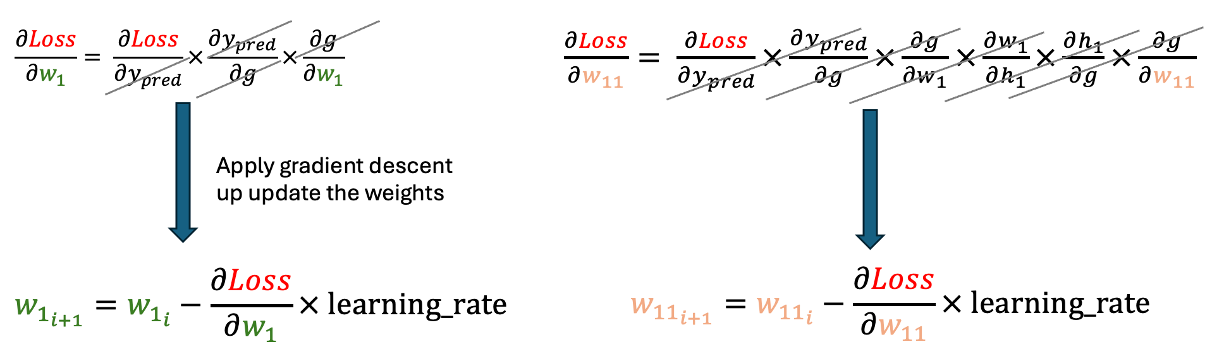

In [40]:
IMG("../AI_USU/Images/NN_opt1.png")

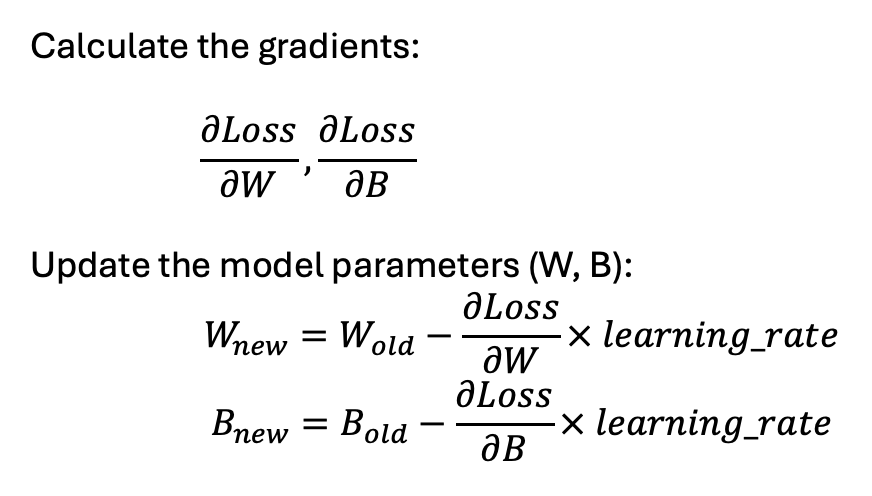

In [41]:
IMG("../AI_USU/Images/NN_bwd.png")

##### Code:

In [10]:
class MetricsCB_sample(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean() # Creates an instance of the Mean() class

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x, y, *_ = to_cpu(learn.batch)
        preds = learn.preds.as_subclass(torch.Tensor).float().view(-1)
        #preds = to_cpu(learn.preds)
        preds = to_cpu(preds)
        y = y.float().as_subclass(torch.Tensor).float().view(-1)
        
        # Print shapes for debugging
        #print(f'preds: {preds}, y: {y}')
        #print(f'After batch - preds shape: {preds.shape}, y shape: {y.shape}')

        # Ensure shapes are consistent
        if preds.shape != y.shape:
            y = y.view_as(preds)
            #preds = preds.view_as(y)

        for m in self.metrics.values():
            m.update(preds, y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))


metrics = MetricsCB_sample(accuracy=BinaryAccuracy())
cbs_sample = [DeviceCB(), metrics, ProgressCB(plot=True)]  

def custom_bce_loss(input, target):
    input = input.as_subclass(torch.Tensor).float().view(-1)
    target = target.as_subclass(torch.Tensor).float().view(-1)
    input = input.to(def_device)
    target = target.to(def_device)
    return F.binary_cross_entropy(input, target.view_as(input))

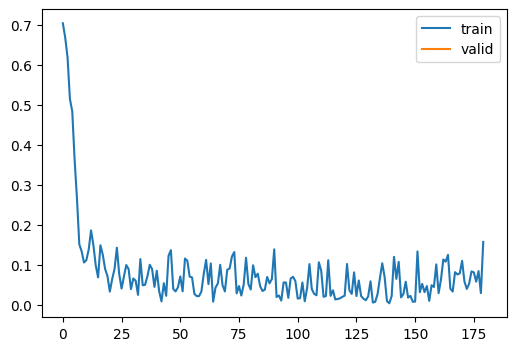

In [11]:
learn_sample = TrainLearner(model_mnist_sample, dls_sample, loss_func=custom_bce_loss, lr=0.4, cbs=cbs_sample, opt_func=torch.optim.SGD)
learn_sample.fit(1)

That's 99.2% accuracy on classification of digits either 3 vs 7 with a neurnal network of 1 layer, using about 8000 parameters!

##### Pics

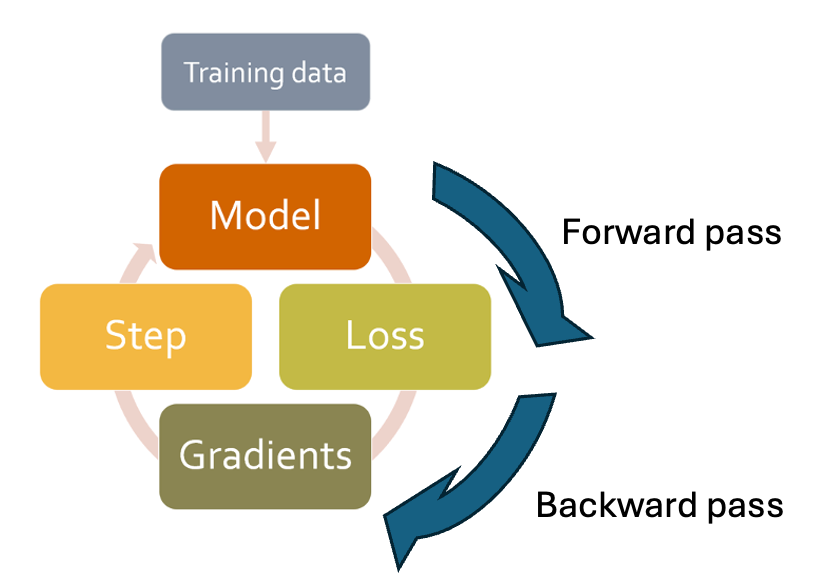

In [42]:
IMG("../AI_USU/Images/NN_summ.png")

And that's it!
- All complicated neural networks rely on this basic principles

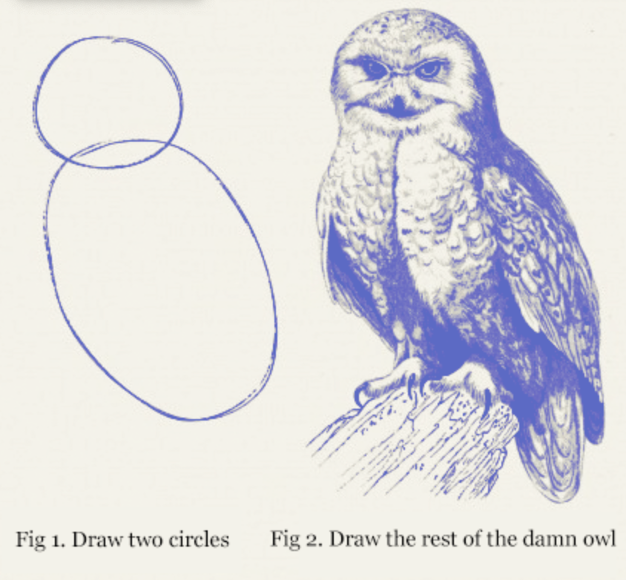

In [43]:
IMG("../AI_USU/Images/NN_owl.png")

## Multilayer Neural Networks
- Using only one hidden layer with 10 nodes in limited in the complexity of data it can model
- Our simple neurnetwork only has 7861 parameters, for reference, GPT-4 have 1.76 TRILLION
- What if we have a slightly more complicated dataset?

### MNIST dataset: handwritten digits 0-9

##### Code

In [29]:
current_directory = Path.cwd()
path_data = current_directory / '..' / 'nbs' / 'data'
path_gz = path_data / 'mnist.pkl.gz'
path_gz = path_gz.resolve()
print(path_gz)
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

/notebooks/nbs/data/mnist.pkl.gz


In [4]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

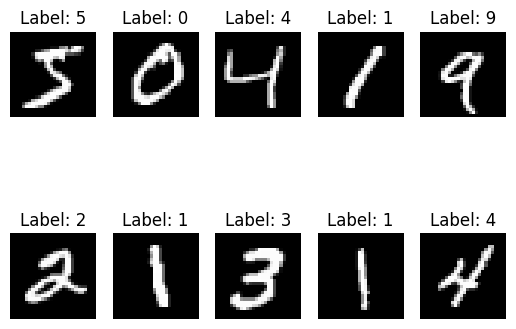

In [5]:
for i in range(10):
    plt.subplot(2, 5, i+1) 
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')  
    plt.title(f'Label: {y_train[i]}') 
    plt.axis('off')
plt.show() 

To predict 10 separate hand-written digits, lets train a wider and deeper model:

##### Pics

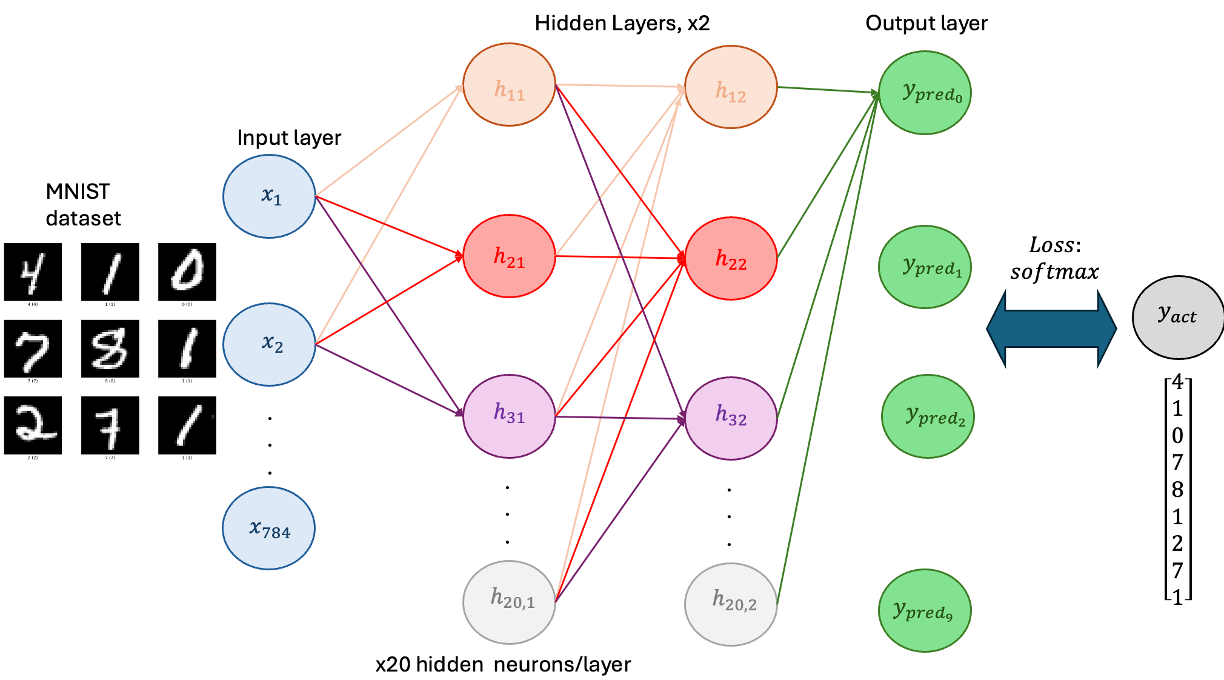

In [45]:
IMG("../AI_USU/Images/NN_deep.png")

Total parameters: 16,920

##### Code

In [6]:
n,m = x_train.shape[0], x_train.shape[1]
c = y_train.max()+1
nh = 20
bs = 100

In [7]:
model = nn.Sequential(
    nn.Linear(m,nh),
    nn.ReLU(),
    nn.Linear(nh,nh),
    nn.ReLU(),
    nn.Linear(nh,c))

In [8]:
train_ds, valid_ds = Dataset(x_train,y_train), Dataset(x_valid,y_valid)
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
dls = miniai_DataLoaders(train_dl,valid_dl)

In [9]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=optim.SGD)

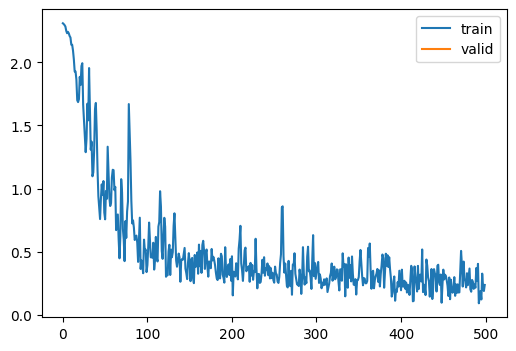

In [10]:
learn.fit(1)

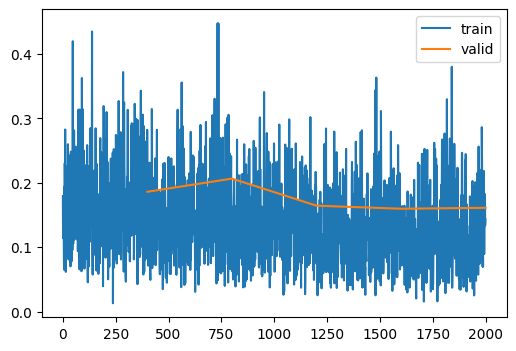

In [67]:
learn.fit(5)

##### Sidebar1: What actually going on with each parameters through every iteration:

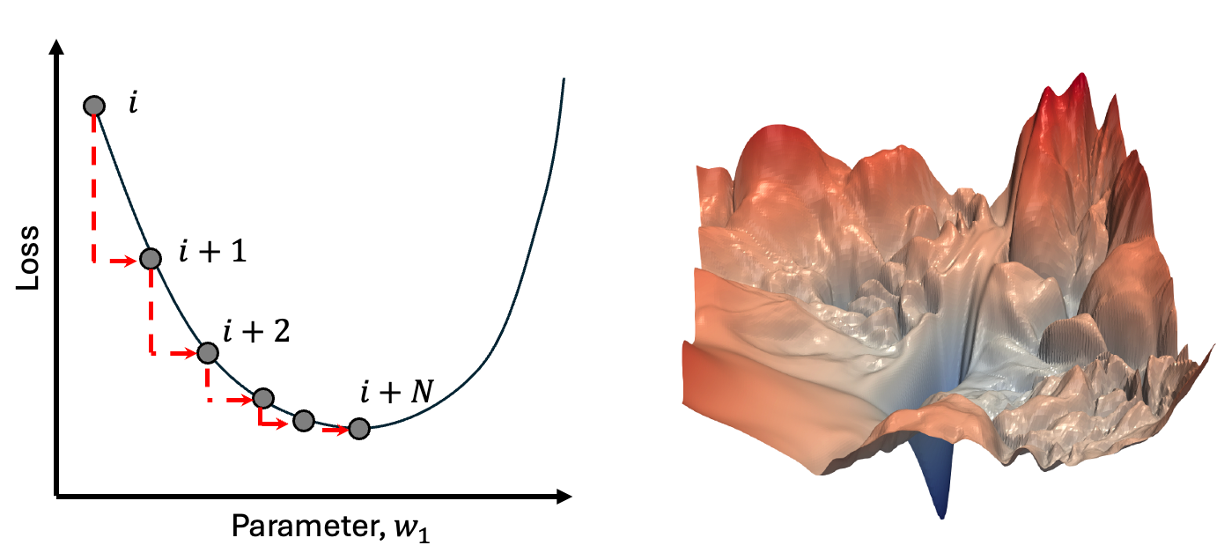

In [46]:
IMG("../AI_USU/Images/NN_loss_landscape.png")

##### Sidebar2: Over vs underfitting

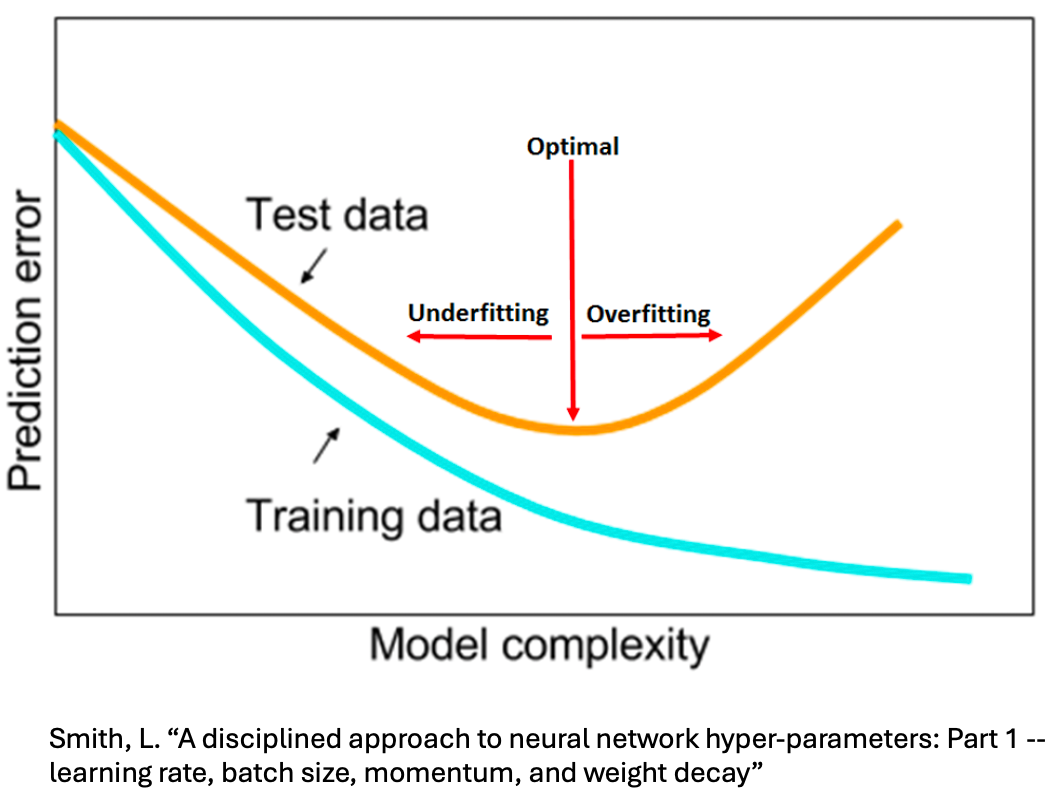

In [47]:
IMG("../AI_USU/Images/NN_Fitting.png")

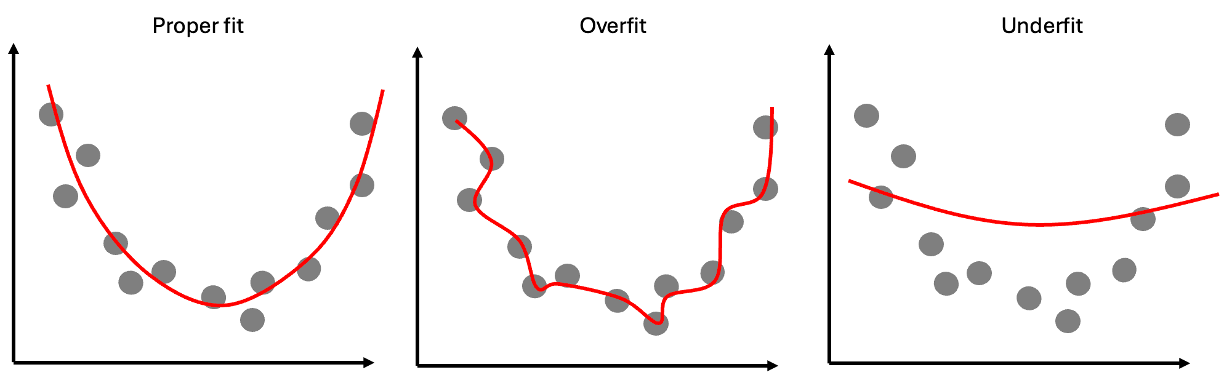

In [48]:
IMG("../AI_USU/Images/NN_over_under_fit.png")

End sidebar

## Convolutional Neural Networks
- We achieve a ~93% accuracy using a linear/dense neural network with 16,330 parameters
- Is there a way to achieve better accuracy while using less parameters?
- Linear neural networks treat nearby pixels as if they're independent of each other. In realy, we know nearby pixels are related to each other (eg if a pixel = 255, good chance nearby ones are > 0. Can we use spatial relationships to reduce the number of parameters? 

### What is a convolution:
- Just a mathematical operation: multiple and adds numbers together. Put these operations on a GPU and it goes really fast.
- Let's create a "filter" to look for visually distinct parts of an image
- remember:

- 3 is characterized by a series of diagonal, horizontal, and vertial edges
- create a filter:

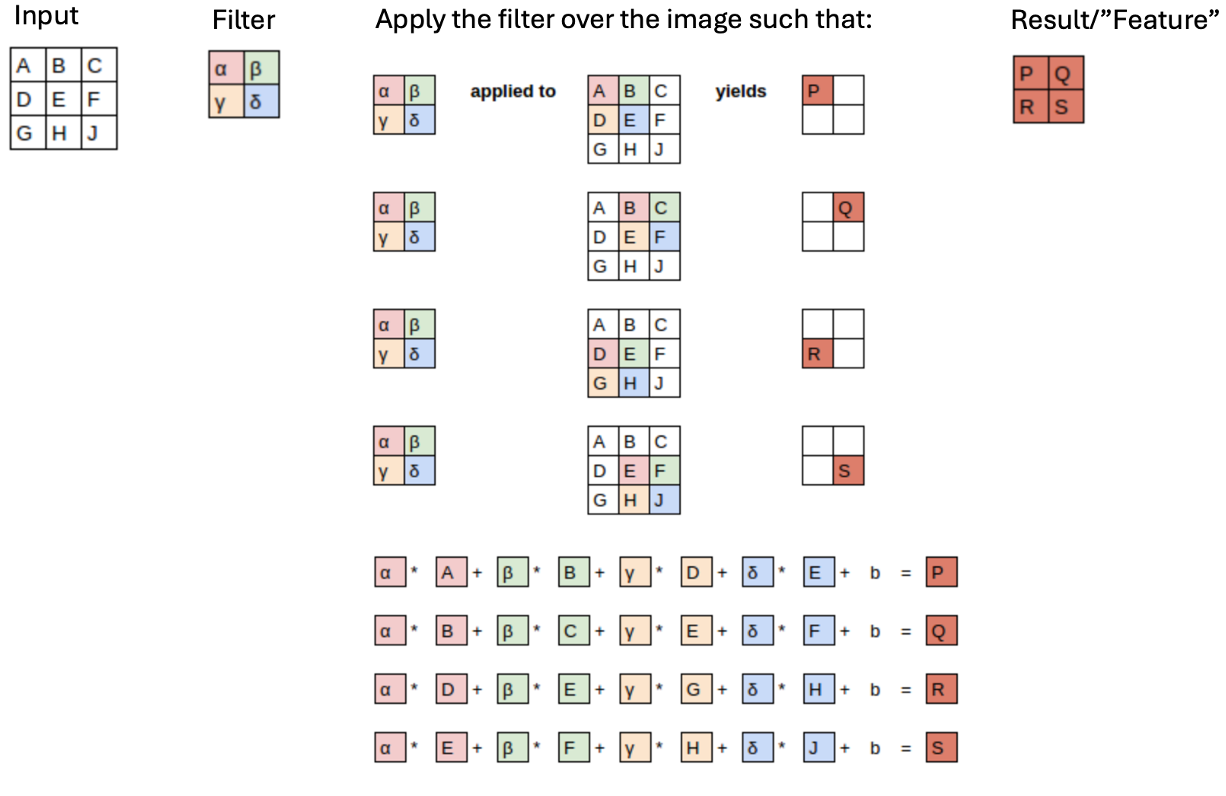

In [49]:
IMG("../AI_USU/Images/CNN_overview.png")

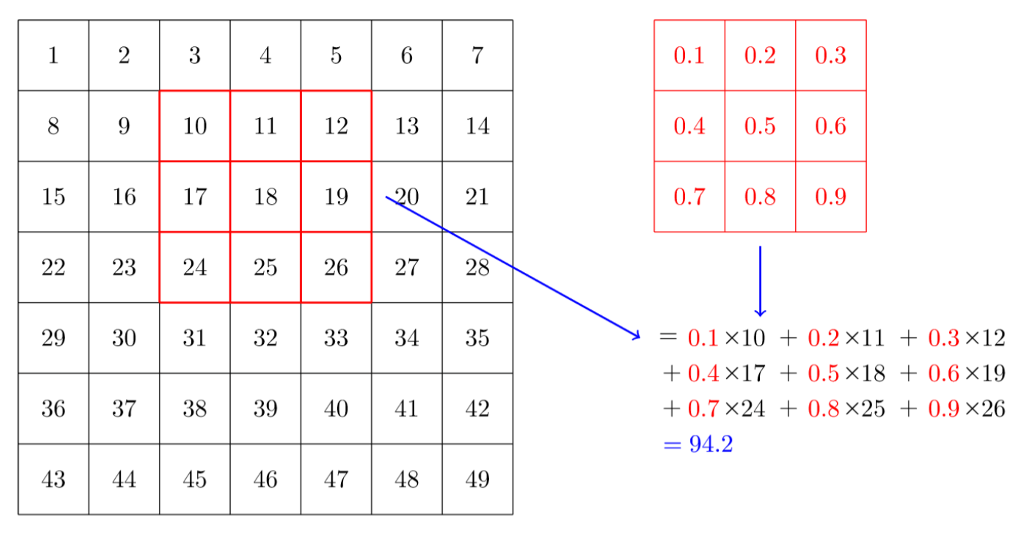

In [50]:
IMG("../AI_USU/Images/CNN_example_calc.png")

In [72]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

edges = torch.stack([top_edge, left_edge, diag1_edge])

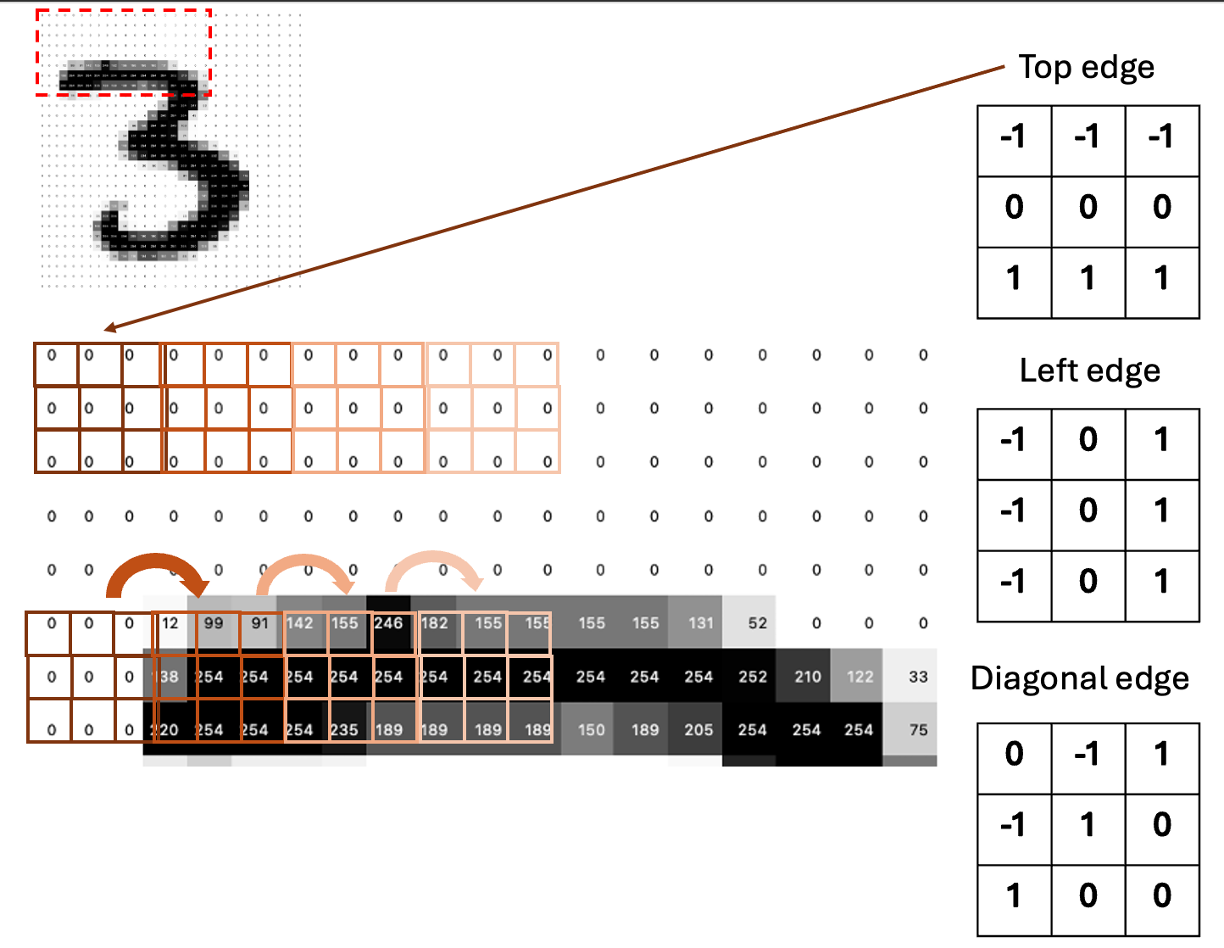

In [51]:
IMG("../AI_USU/Images/CNN_filters.png")

In [76]:
def apply_kernel(im, row, col, kernel): return (im[row-1:row+2,col-1:col+2] * kernel).sum()

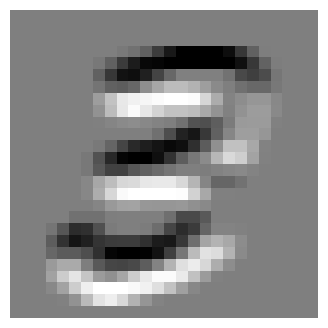

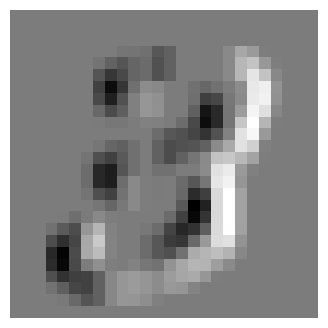

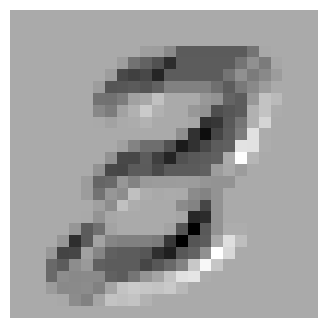

In [87]:
for kernel in edges:
    new_im = tensor([[apply_kernel(x_imgs[7], i, j, kernel) for j in range(1,27)] for i in range(1,27)])
    show_image(new_im, figsize=(4,4))

### Create a neural net applying knowledge of convolutions:

In [30]:
x_train_cnn, y_train_cnn, x_valid_cnn, y_valid_cnn = x_train.view(-1,1,28,28) , y_train, x_valid.view(-1,1,28,28) , y_valid

In [31]:
x_train_cnn.shape, y_train_cnn.shape, x_valid_cnn.shape, y_valid_cnn.shape

(torch.Size([50000, 1, 28, 28]),
 torch.Size([50000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

In [32]:
train_ds_cnn, valid_ds_cnn = Dataset(x_train_cnn,y_train_cnn), Dataset(x_valid_cnn,y_valid_cnn)
train_dl_cnn,valid_dl_cnn = get_dls(train_ds_cnn, valid_ds_cnn, bs)
dls_cnn = miniai_DataLoaders(train_dl_cnn,valid_dl_cnn)

In [33]:
simple_cnn = nn.Sequential(
    conv(1,4),              # 14x14
    conv(4,8),              # 7x7
    conv(8,16),             # 4x4
    conv(16,32),            # 2x2
    conv(32,10, act=False), # 1x1
    nn.Flatten()
).to(def_device)

In [34]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn_cnn = TrainLearner(simple_cnn, dls_cnn, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=optim.SGD)

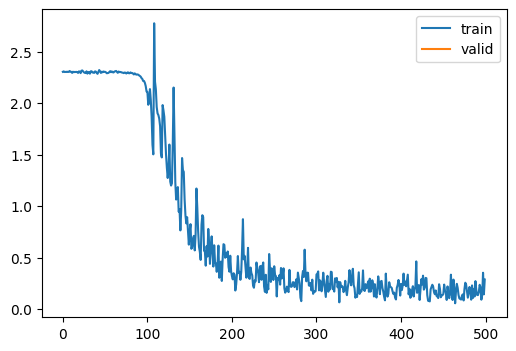

In [28]:
learn_cnn.fit(1)

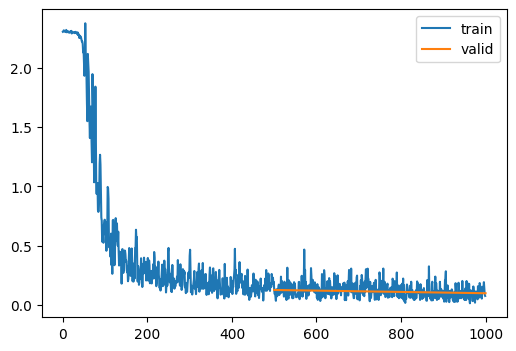

In [35]:
learn_cnn.fit(2)

Just achieve 97% accuracy after 2 epochs compared to 94% with a linear model and we only used 9034 parameters (9k compared to 16K, 56% of the parameters)!

##### Pics

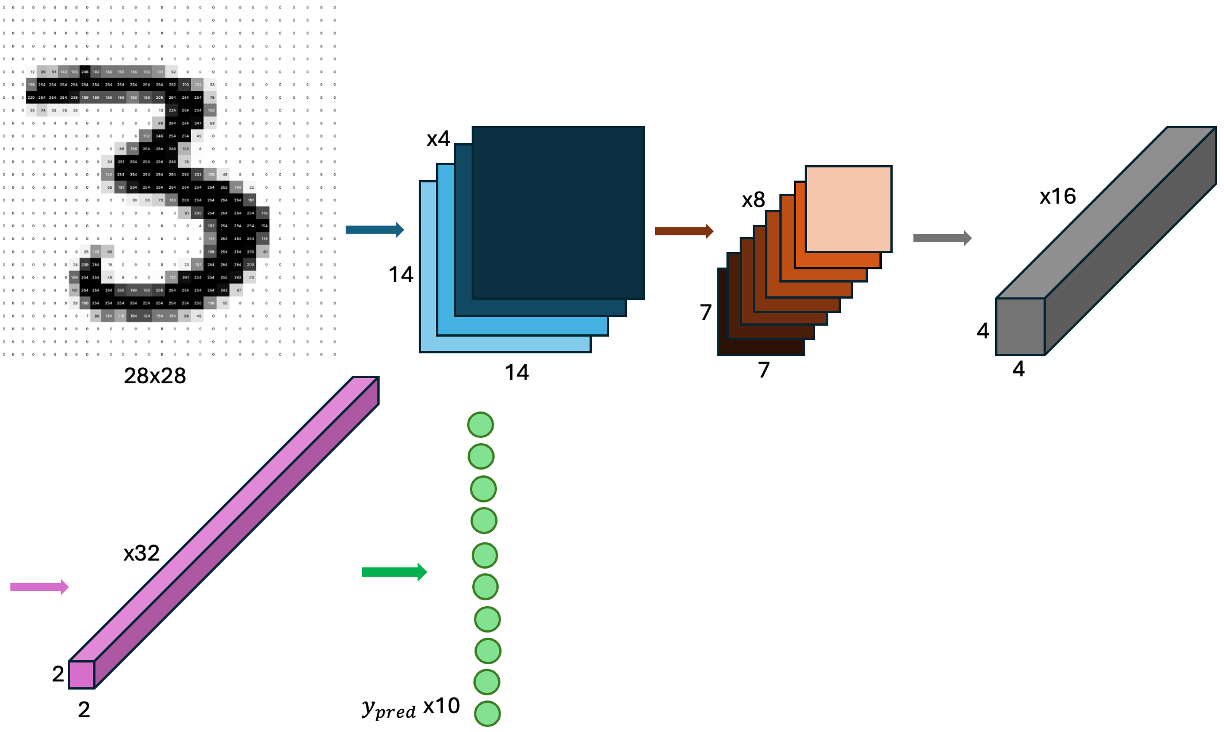

In [53]:
IMG("../AI_USU/Images/CNN_Simple.png")

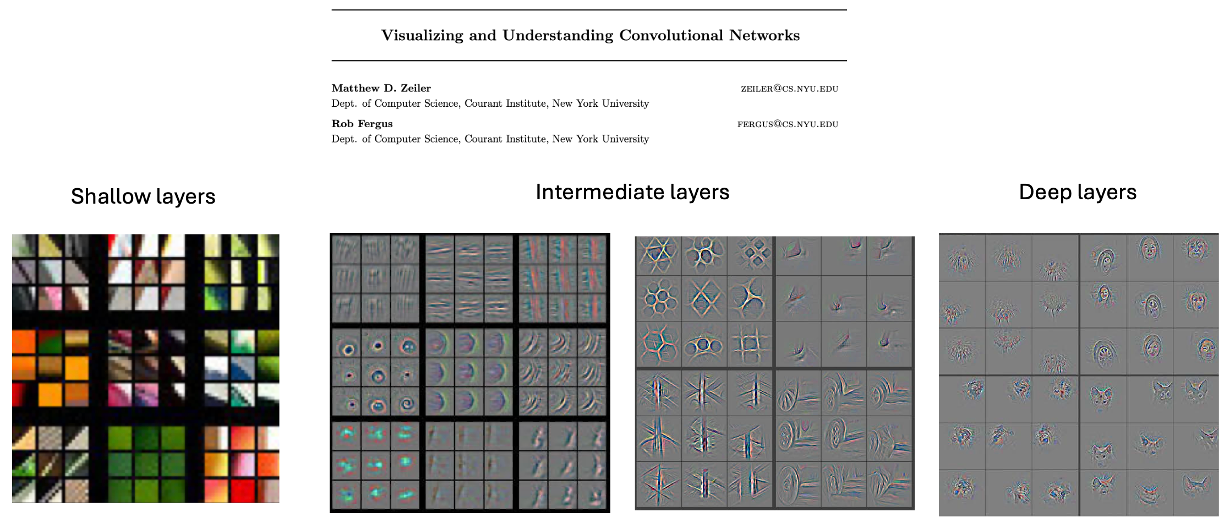

In [37]:
IMG("../AI_USU/CNN_visualizing.png")

## IF TIME: show excel.conv spreadsheet, showing receptive fields

## IF TIME: CXR Classification

# Natural Language Processing (NLP)
- Computers only know 1's and 0's, they dont know words. 
- Need to convert words/letters to numbers
- Pass the numbers through a neural network to predict the next word in a sentence
- Relatively newer field compared to computer vision. NLP models only became useful about 5 years. Computer vision models have been effecive for longer.
- Basic language models are only trained to predict the next word in a sentence (form of self-supervised learning: training a model using labels embedded in the independent variable)

#### Imports

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter
from fastai.text.all import *
path_nlp = untar_data(URLs.HUMAN_NUMBERS)
from fastai.learner import Learner as Learner_fastai
from fastai.learner import Module as Module_fastai

## Basic steps

#### Imports

### Step 1: Tokenization
- reaking down a sequence of text into smaller units, called tokens. These tokens can be as small as individual characters or as large as entire words or phrases.
- word tokenizaiton vs subword

Let's use an example of getting moview reviews from IMDB:

In [3]:
text = "Diffuse bilateral interstitial and alveolar opacifications, more prominent in the lower lobes, consistent with multifocal pneumonia."
tokens = word_tokenize(text)
print(tokens)

['Diffuse', 'bilateral', 'interstitial', 'and', 'alveolar', 'opacifications', ',', 'more', 'prominent', 'in', 'the', 'lower', 'lobes', ',', 'consistent', 'with', 'multifocal', 'pneumonia', '.']


In [4]:
print(word_tokenize("I cannot have a $1.00."))

['I', 'can', 'not', 'have', 'a', '$', '1.00', '.']


### Step 2: Numericalization
- assign each token a unique number

In [6]:
vocab = Counter(tokens)
vocab = {word: idx for idx, (word, _) in enumerate(vocab.items())}
indices = [vocab[token] for token in tokens]
print(vocab)
print(indices)

{'Diffuse': 0, 'bilateral': 1, 'interstitial': 2, 'and': 3, 'alveolar': 4, 'opacifications': 5, ',': 6, 'more': 7, 'prominent': 8, 'in': 9, 'the': 10, 'lower': 11, 'lobes': 12, 'consistent': 13, 'with': 14, 'multifocal': 15, 'pneumonia': 16, '.': 17}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 6, 13, 14, 15, 16, 17]


In [7]:
for k,v in vocab.items():
    print(k)

Diffuse
bilateral
interstitial
and
alveolar
opacifications
,
more
prominent
in
the
lower
lobes
consistent
with
multifocal
pneumonia
.


### Step 3: Create an embedding matrix:
- Assign a vector (unique set of numbers) for every for every token. Lets you encode semantic meaning in each token.
- Practical example of the word "heart"
    - Can have many different meanings: heart->love, heart->grit, heart->medical [anatomy, physiology, pathology: heart failure (edema, SOB)].
- Assigning a lot list of numbers to each token is a way that a computer can encapsulate meaning in a word and relationships to other words in a very high dimensional space
    - ex2: “cat” might be represented by a set of numbers like [0.1, -0.3, 0.5, ...], and the word “dog” might be [0.2, -0.4, 0.6, ...], but "car" might be [5.4, 7.2, 9.6, ...]
- Embedding matrics are pre-trained 

In [10]:
glove_embeddings = {}
for k,_ in vocab.items():
    glove_embeddings[k] = np.random.randn(10)
    
for i, (k, v) in enumerate(glove_embeddings.items()):
    formatted_embedding = ', '.join(f'{x:6.2f}' for x in v)  
    print(f'Token: {k: <15}, Numerical: {i:<5}, Embedding: [{formatted_embedding}]')

Token: Diffuse        , Numerical: 0    , Embedding: [  0.50,  -0.14,   0.65,   1.52,  -0.23,  -0.23,   1.58,   0.77,  -0.47,   0.54]
Token: bilateral      , Numerical: 1    , Embedding: [ -0.46,  -0.47,   0.24,  -1.91,  -1.72,  -0.56,  -1.01,   0.31,  -0.91,  -1.41]
Token: interstitial   , Numerical: 2    , Embedding: [  1.47,  -0.23,   0.07,  -1.42,  -0.54,   0.11,  -1.15,   0.38,  -0.60,  -0.29]
Token: and            , Numerical: 3    , Embedding: [ -0.60,   1.85,  -0.01,  -1.06,   0.82,  -1.22,   0.21,  -1.96,  -1.33,   0.20]
Token: alveolar       , Numerical: 4    , Embedding: [  0.74,   0.17,  -0.12,  -0.30,  -1.48,  -0.72,  -0.46,   1.06,   0.34,  -1.76]
Token: opacifications , Numerical: 5    , Embedding: [  0.32,  -0.39,  -0.68,   0.61,   1.03,   0.93,  -0.84,  -0.31,   0.33,   0.98]
Token: ,              , Numerical: 6    , Embedding: [ -0.48,  -0.19,  -1.11,  -1.20,   0.81,   1.36,  -0.07,   1.00,   0.36,  -0.65]
Token: more           , Numerical: 7    , Embedding: [  0.36, 

### Step 4: Pass the embedding matrix as the input of a neural network to predict the next word
- many types of language models, beyond the scope of this lecture
- let's talk about a "simple" model that's in your learning objects: a Recurrent Neural Network (RNN)

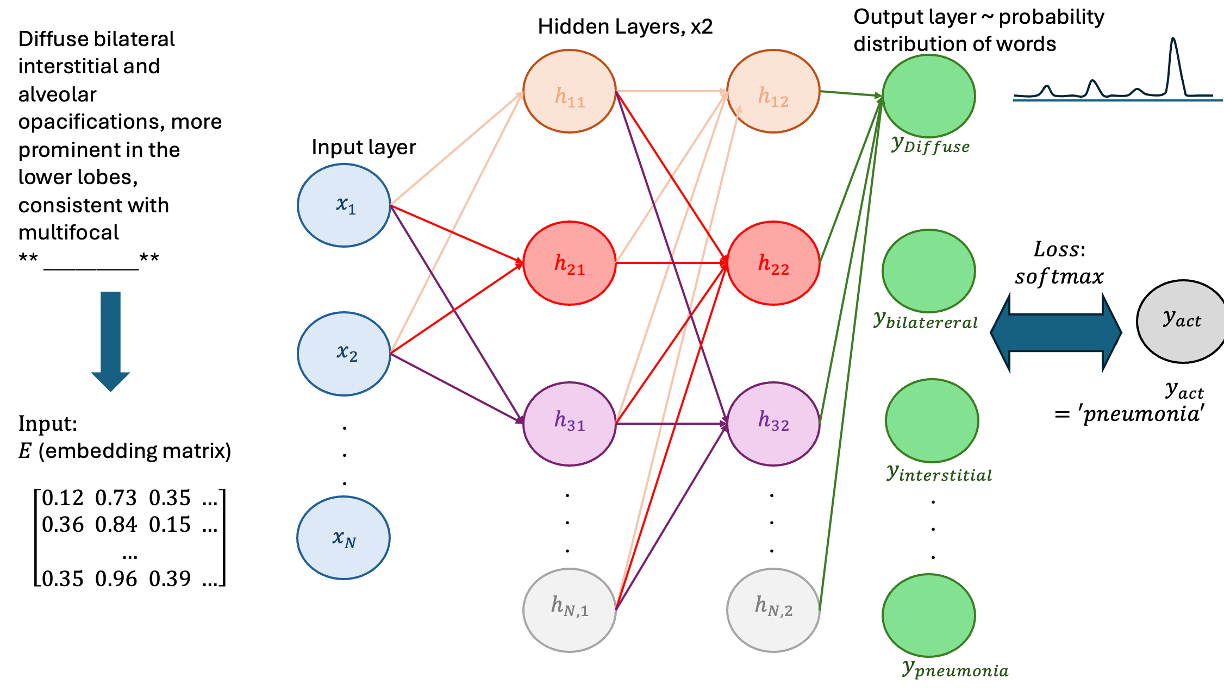

In [54]:
IMG("../AI_USU/Images/NLP_overview.png")

This is essentially a classification problem. Instead of predicting an label given an image, we predict the next word (token) give a sequence of previous words. Our neural network tells us the probability that each word in our vocab will be the "correct" next word in the sentence.

## Recurrent Neural Networks
- Literally guesses the next word in a sentence/sequence
- Good for small sentences but performance quickly deteriorates
- Aren't used often today but I assume they're in your learning objective because they from the basis of LLMs like transformers (eg GPT-4)

### Intro

#### Pics

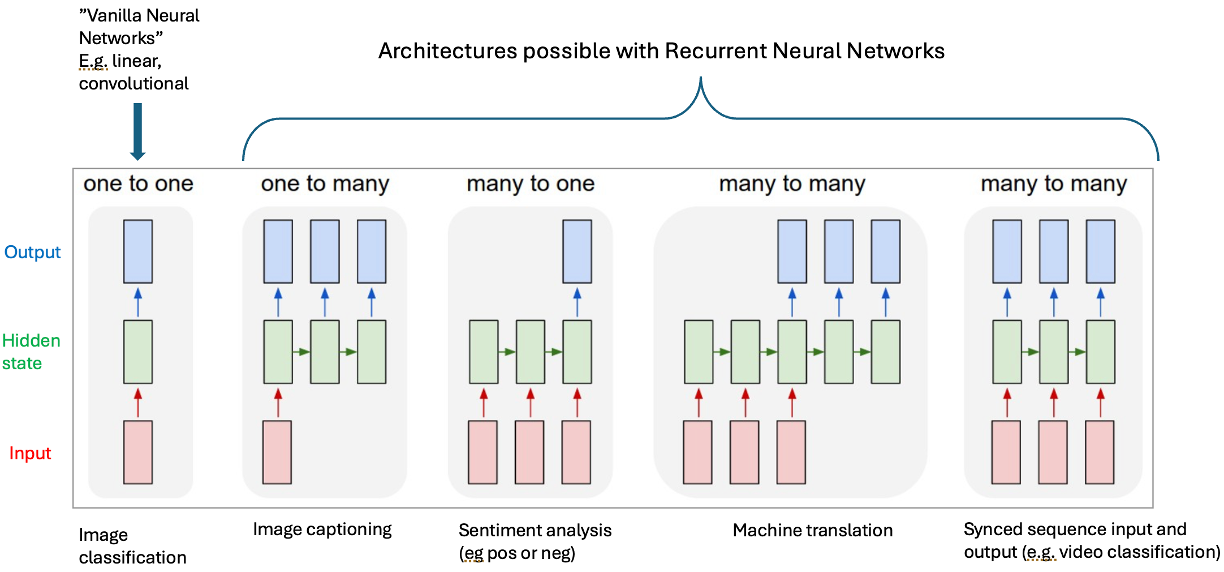

In [55]:
IMG("../AI_USU/Images/RNN_Overview.png") #http://karpathy.github.io/2015/05/21/rnn-effectiveness/

Notice that in every case are no pre-specified constraints on the lengths sequences because the recurrent transformation (green) is fixed and can be applied as many times as we like.

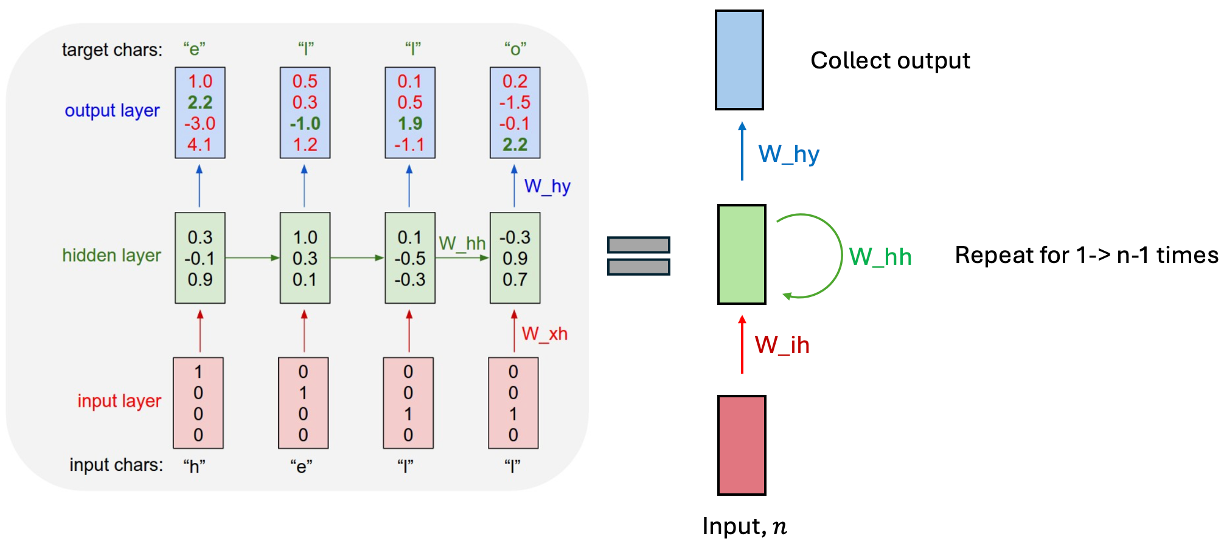

In [56]:
IMG("../AI_USU/Images/RNN_diagram.png")

#### Code

In [5]:
lines = L()
with open(path_nlp/'train.txt') as f: lines +=L(*f.readlines())
with open(path_nlp/'valid.txt') as f: lines +=L(*f.readlines())
text = ' . '.join([l.strip() for l in lines])
text[:97], text[10005:10100], text[300023:300110]

('one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen .',
 ' four hundred fifty four . four hundred fifty five . four hundred fifty six . four hundred fift',
 'eight thousand three hundred twenty three . eight thousand three hundred twenty four . ')

In [6]:
tokens = text.split(' ') 
tokens[:10], tokens[-10:len(tokens)]

(['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.'],
 ['hundred',
  'ninety',
  'eight',
  '.',
  'nine',
  'thousand',
  'nine',
  'hundred',
  'ninety',
  'nine'])

In [7]:
vocab = L(*tokens).unique()
for v in vocab:
    print(v)
len(vocab)

one
.
two
three
four
five
six
seven
eight
nine
ten
eleven
twelve
thirteen
fourteen
fifteen
sixteen
seventeen
eighteen
nineteen
twenty
thirty
forty
fifty
sixty
seventy
eighty
ninety
hundred
thousand


30

In [8]:
word2idx = {w:i for i,w, in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
nums[:10], nums[-10:-1], len(nums)

((#10) [0,1,2,1,3,1,4,1,5,1], (#9) [28,27,8,1,9,29,9,28,27], 63095)

### Task 1: Predict the next word given the previous 4 words.
- independent variables: chunks of 4 words: ['one', '.', 'two', '.']
- dependent variable: 5th word: 'three'

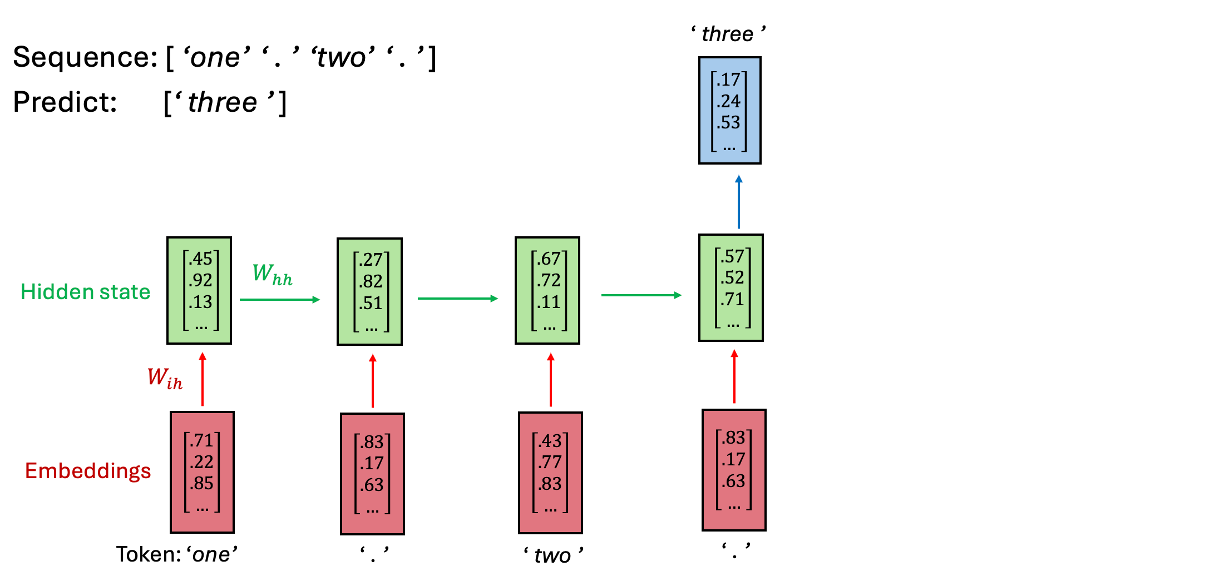

In [57]:
IMG("../AI_USU/Images/RNN_seq1.png")

In [10]:
L((tokens[i:i+4],tokens[i+4]) for i in range(0,len(tokens)-5,4))

(#15773) [(['one', '.', 'two', '.'], 'three'),(['three', '.', 'four', '.'], 'five'),(['five', '.', 'six', '.'], 'seven'),(['seven', '.', 'eight', '.'], 'nine'),(['nine', '.', 'ten', '.'], 'eleven'),(['eleven', '.', 'twelve', '.'], 'thirteen'),(['thirteen', '.', 'fourteen', '.'], 'fifteen'),(['fifteen', '.', 'sixteen', '.'], 'seventeen'),(['seventeen', '.', 'eighteen', '.'], 'nineteen'),(['nineteen', '.', 'twenty', '.'], 'twenty'),(['twenty', 'one', '.', 'twenty'], 'two'),(['two', '.', 'twenty', 'three'], '.'),(['.', 'twenty', 'four', '.'], 'twenty'),(['twenty', 'five', '.', 'twenty'], 'six'),(['six', '.', 'twenty', 'seven'], '.'),(['.', 'twenty', 'eight', '.'], 'twenty'),(['twenty', 'nine', '.', 'thirty'], '.'),(['.', 'thirty', 'one', '.'], 'thirty'),(['thirty', 'two', '.', 'thirty'], 'three'),(['three', '.', 'thirty', 'four'], '.')...]

In [11]:
seqs = L((tensor(nums[i:i+4]),tensor(nums[i+4])) for i in range(0,len(nums)-5,4))
seqs

(#15773) [(tensor([0, 1, 2, 1]), tensor(3)),(tensor([3, 1, 4, 1]), tensor(5)),(tensor([5, 1, 6, 1]), tensor(7)),(tensor([7, 1, 8, 1]), tensor(9)),(tensor([ 9,  1, 10,  1]), tensor(11)),(tensor([11,  1, 12,  1]), tensor(13)),(tensor([13,  1, 14,  1]), tensor(15)),(tensor([15,  1, 16,  1]), tensor(17)),(tensor([17,  1, 18,  1]), tensor(19)),(tensor([19,  1, 20,  1]), tensor(20)),(tensor([20,  0,  1, 20]), tensor(2)),(tensor([ 2,  1, 20,  3]), tensor(1)),(tensor([ 1, 20,  4,  1]), tensor(20)),(tensor([20,  5,  1, 20]), tensor(6)),(tensor([ 6,  1, 20,  7]), tensor(1)),(tensor([ 1, 20,  8,  1]), tensor(20)),(tensor([20,  9,  1, 21]), tensor(1)),(tensor([ 1, 21,  0,  1]), tensor(21)),(tensor([21,  2,  1, 21]), tensor(3)),(tensor([ 3,  1, 21,  4]), tensor(1))...]

In [12]:
bs = 64
cut = int(len(seqs)*0.8)
#dls = DataLoaders.from_dsets(seqs[:cut],seqs[cut:], bs = bs, shuffle = False).cuda()

In [15]:
class RNNModel(Module_fastai):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(1).to(torch.device("cuda"))
        
    def forward(self, x):
        for i in range(4):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out
    
    def reset(self): self.h = 0

In [16]:
def group_chunks(ds,bs):
    m = len(ds)//bs #328, 21031, 64
    new_ds = L()
    for i in range(m): 
        new_ds+=L(ds[i+m*j] for j in range(bs))
    return new_ds

In [17]:
#group_chunks(seqs[:cut],bs),len(group_chunks(seqs[:cut],bs)) #328*64*0.8

In [18]:
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut],bs),
    group_chunks(seqs[cut:],bs),
    bs = bs, drop_last = True, shuffle = False).cuda()

In [19]:
model_RNN1 = RNNModel(len(vocab),64).to(def_device)

In [20]:
learn_nlp1 = Learner_fastai(dls, model_RNN1, loss_func=F.cross_entropy, metrics=accuracy, cbs=ModelResetter)

In [21]:
learn_nlp1.fit_one_cycle(5, 3e-3)

- For 5 epochs, accuracy 49%, run time: 24 sec  (65 sec on CPU)
- Saw evidence of overfitting at the last epoch
- Total model parameters: 8030

### Task 2: Same as Task 1, except output the next word for every word passed in
- Independent variable is still a sequence: eg ['one','.','two','.']
- Dependent variable is now that sequence shifted over one character to the right: ['.','two','.','three']

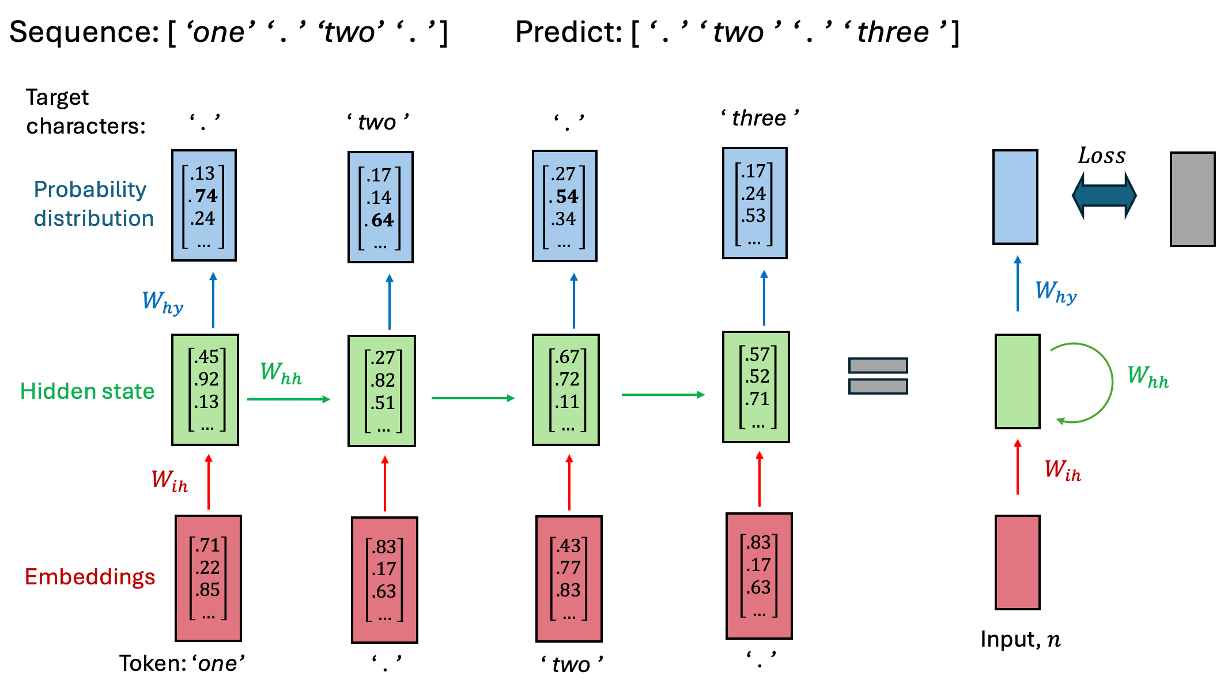

In [58]:
IMG("../AI_USU/Images/RNN_seq2.png")

In [22]:
sl = 4 
seqs = L((tensor(nums[i:i+sl]),tensor(nums[i+1:i+sl+1])) for i in range(0,len(nums)-sl-1,sl)) #3943 indiv sequences in total dataset
cut = int(len(seqs)*0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut],bs),
    group_chunks(seqs[cut:],bs),
    bs = bs, drop_last = True, shuffle = False).cuda()

In [23]:
[L(vocab[o] for o in s) for s in seqs[0]] #new dependent variable

[(#4) ['one','.','two','.'], (#4) ['.','two','.','three']]

In [47]:
class RNNModel2(Module_fastai):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(1).to(torch.device("cuda"))
        
    def forward(self, x):
        outs = []
        for i in range(sl):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs,dim=1)  #outs = [bs,sl,vocab_sz], prob distro for each bs and each element in sl
    
    def reset(self): self.h = 0

In [48]:
def loss_func(inp,targ):
    return F.cross_entropy(inp.view(-1,len(vocab)),targ.view(-1)) #comparing [1024,30] to [1024]

In [49]:
model_RNN2 = RNNModel2(len(vocab),64).to(def_device)

In [50]:
learn_nlp2 = Learner_fastai(dls, model_RNN2, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)
learn_nlp2.fit_one_cycle(5,3e-3)

- Accuracy: 50%
- Run time: 25 sec, theoretically more calculations (more weight updates, gradient calculations, etc) but overall affect is neglegible 
- Evidence of overfitting at 5th epoch
- However: approach is often more useful and flexible.
    - Want to generate one word after the other (like ChatGPT), not just every 5th word.
- Total model parameters: 8030

### Task 3: Same as Task 2, but increase the sequence length to 16.
- Independent variable: ['one','.','two','.','three','.','four','.','five','.','six','.','seven','.','eight','.']
- Dependent variable: ['.','two','.','three','.','four','.','five','.','six','.','seven','.','eight','.','nine']

In [24]:
sl = 16 
seqs = L((tensor(nums[i:i+sl]),tensor(nums[i+1:i+sl+1])) for i in range(0,len(nums)-sl-1,sl)) 
cut = int(len(seqs)*0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut],bs),
    group_chunks(seqs[cut:],bs),
    bs = bs, drop_last = True, shuffle = False).cuda()

In [25]:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#16) ['one','.','two','.','three','.','four','.','five','.','six','.','seven','.','eight','.'],
 (#16) ['.','two','.','three','.','four','.','five','.','six','.','seven','.','eight','.','nine']]

In [54]:
learn_nlp3 = Learner_fastai(dls, model_RNN2, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)
learn_nlp3.fit_one_cycle(5,3e-3)

- About the same accuracy 60%
    - Intuitively would expect this to be more accuracy than the short sequences because this model has a greater "memory" of the previous sequences. However, one of the limitations of RNNs is that their "memory" of past events is limited
- Faster run time: 16 sec
     - Faster batch processing (less sequences to handle)
     - Longer sequences often better optimized for parallel computing on the GPU
- Earlier evidence of overfitting
- Total model parameters: 8030

### Task 4: Build a deeper network: Stack RNNs on top of each other, otherwise same as Task 3

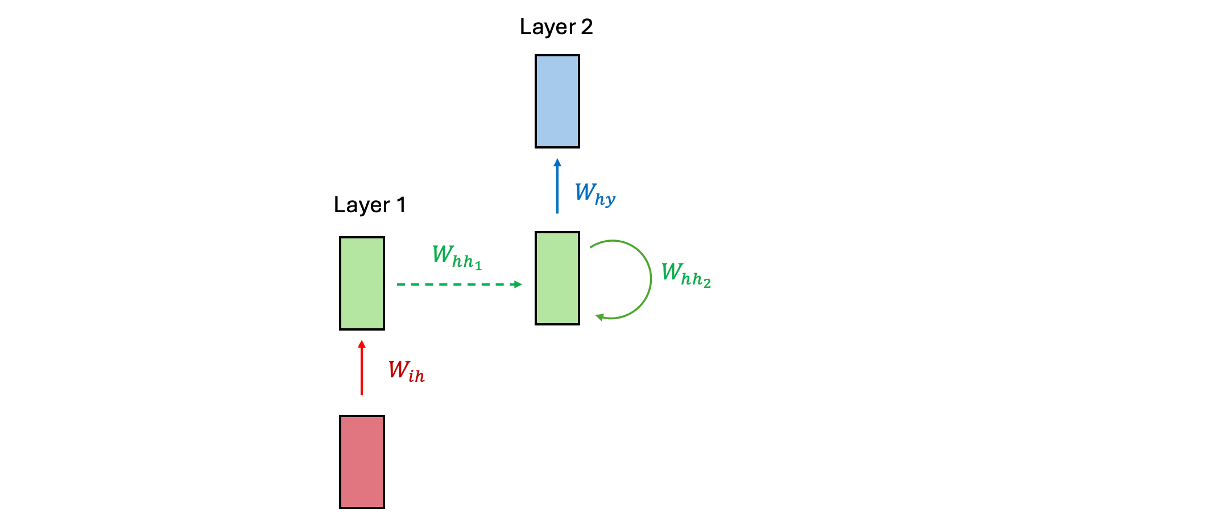

In [59]:
IMG("../AI_USU/Images/RNN_stacked.png")

In [57]:
class RNNModel3(Module_fastai):
    def __init__(self,vocab_sz, n_hidden, n_layers):
        self.h_i = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers,bs,n_hidden).to(torch.device("cuda"))
    
    def forward(self,x):
        res,h = self.rnn(self.h_i(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

In [58]:
model_RNN3 = RNNModel3(len(vocab),64,2).to(def_device)

In [59]:
learn_nlp4 = Learner_fastai(dls, model_RNN3, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)

In [60]:
learn_nlp4.fit_one_cycle(5,3e-3)

Meh
- Worse accuracy: 50%
- Total parameters: 20,510 (over double) but same run time (more parameters != slower run time)
- Deeper networks are not always better. Weights can grow to infinity or shrink to zero creating a very unstable model (vanishing/exploding gradient problem)
- RNNs form the basis of larger models (LSTM, transformers, etc) but by themselves are limited.

### Task 5: Modify an RNN to give it greater memory: LSTMs!
- Long Short-Term Memory model 
- Learn longer term dependencies of sequential data

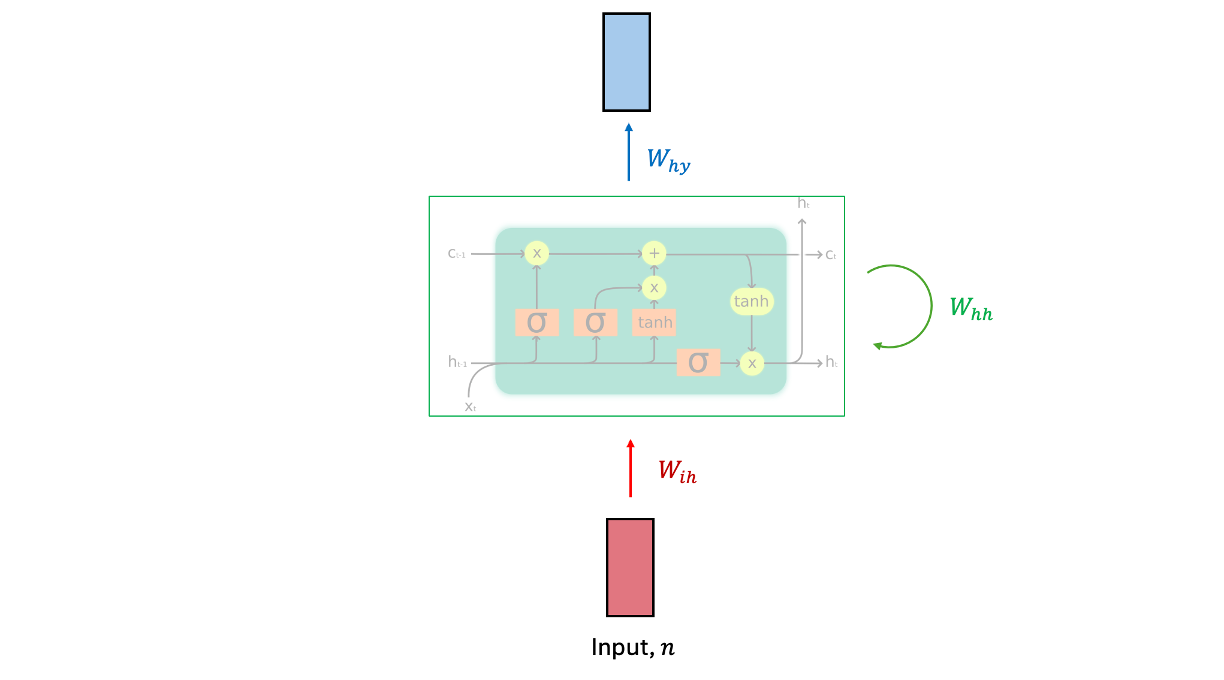

In [60]:
IMG("../AI_USU/Images/LSTM.png")

In [66]:
class LSTMModel(Module_fastai):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden).to(torch.device("cuda")) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [71]:
model_LSTM = LSTMModel(len(vocab),64,2).to(def_device)

In [72]:
learn_nlp5 = Learner_fastai(dls, model_LSTM, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)
learn_nlp5.fit_one_cycle(15,1e-2)

- Now we're getting somewhere!
- Accuracy: 74%, less evidence of overfitting, can train for more epochs. 
- Lets try some regulatizaiton technicques to reduce overfitting.

##### CPU example
- accidentally ran on a CPU, not GPU:

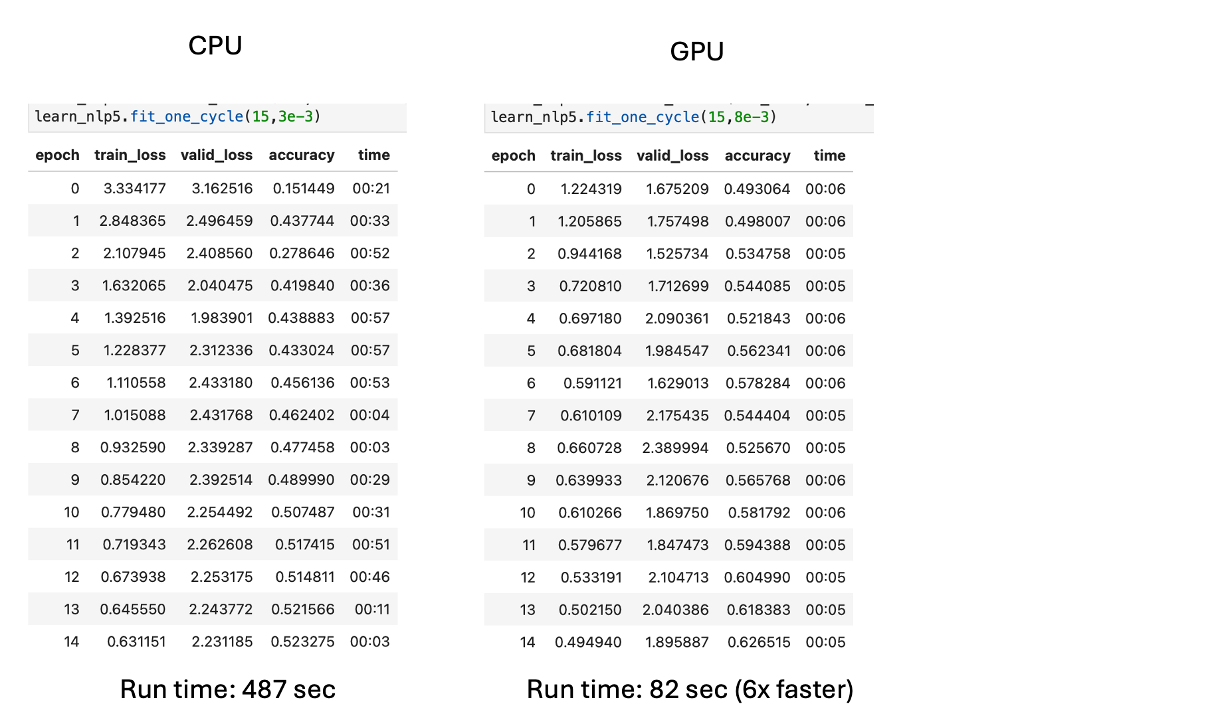

In [62]:
IMG("../AI_USU/Images/CPU_GPU.png")

### Task 6: LSTM with regularization
- regularization: variety of techniques to reduce overfitting

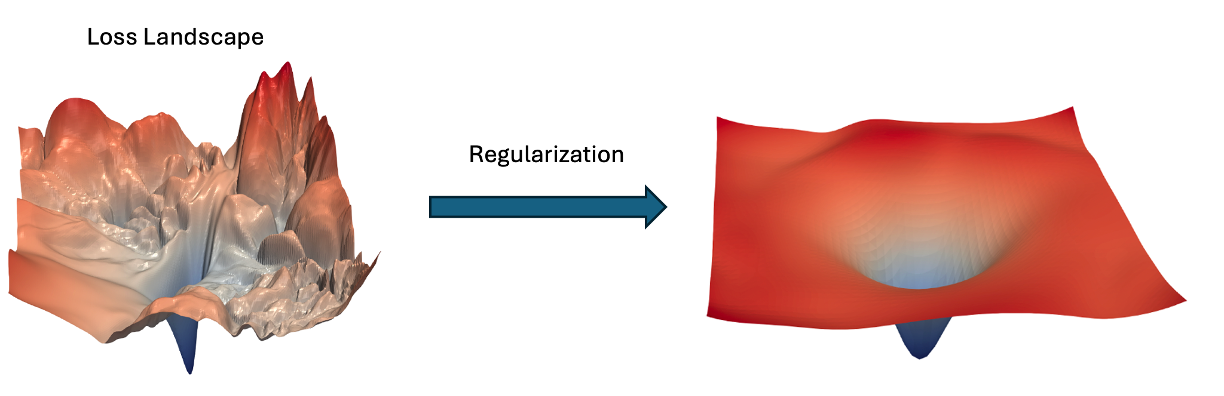

In [61]:
IMG("../AI_USU/Images/NN_regularization.png")

In [26]:
class Dropout(Module_fastai):
    def __init__(self, p): self.p = p
    def forward(self, x):
        if not self.training: return x
        mask = x.new(*x.shape).bernoulli_(1-self.p)
        return x*mask.div(1-self.p)

Activation regularization and temporal activation regularizaiton
- activation regularization: like weight decay, except penalize large activation values (not weights)
    - loss += alpha * activations.square().sum()
- temporal activation regularization: predicting tokens in a sentence, outputs of LSTM should make sense when we read them in the original order
    - make differnece b/t two consecutive activations as small as possible
    - act.shape [bs,sl,n_hidden]  (consecutive activations read along sequence length, sl)
    - loss += beta * (activations[:,1:] - activations[:,:-1]).square().mean()

In [27]:
class LSTMModel_reg(Module_fastai):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden).to(torch.device("cuda")) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        self.out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(self.out)
    
    def reset(self): 
        for h in self.h: h.zero_()

model_LSTM_reg = LSTMModel_reg(len(vocab),64,2,0.5).to(def_device)

learn_nlp6 = Learner_fastai(dls, model_LSTM_reg,
                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=ModelResetter)
learn_nlp6.fit_one_cycle(15,1e-2,wd=0.1)

- Alright! 90% accuracy with just applying two regularization techniques which is barely skratching the surface. 
- Regularization is always a hot topics of interest in trailing neural networks and there no shortage of PhD disserations on the issue.
- If there's one thing I showed you taking you through these notebooks, it's that your DON'T need a PhD to do Deep Learning!